# <u>Geometric image classification substructure of the Hornsund Fjord: Time Series Analysis </u>  <br /> <sub> <span style="font-size:smaller;"> Jullian C.B. Williams </span> </sub> <br /> <sub> <span style="font-size:smaller;"> *Polish Academy of Sciences, Institute of Geophysics, Warsaw, Poland* </span> </sub>


In [128]:
import emoji #<---- Death and taxes are for certain. Try to have fun before you're 6 feet too far under to.
from rich.console import Console #<---- Ditto.

import fiona
import random
import warnings
import argparse, os
import pyarrow as pa
from datetime import datetime
from shapely.geometry import box
from shapely.geometry import shape
from shapely.geometry import Polygon
from shapely.affinity import translate

import numpy as np
import pandas as pd
from osgeo import ogr
from osgeo import gdal #<---- to geospatial env.
import geopandas as gpd

from PIL import Image

import seaborn as sns
import rasterio as rio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.plot import show_hist 
from rasterstats import zonal_stats
from rasterio.features import shapes
from rasterio.plot import adjust_band
from rasterio.features import rasterize

import seaborn as sns
import matplotlib.image
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib import patches as mpatches
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

from spectral import *
from sklearn import svm
from scipy import stats
from scipy import ndimage
from scipy import fftpack
from sklearn.svm import SVC
from scipy.fft import fft, ifft
from scipy.ndimage import zoom
from scipy.ndimage import sobel
from scipy.stats import entropy
import spectral.io.envi as envi #run PCA
from sklearn.svm import LinearSVC
from skimage import io, transform # from scipy.misc import imresize  <---- here...we...go..
from scipy.stats import normaltest
from skimage.morphology import disk #manage disk while running.
from skimage.segmentation import slic
from sklearn.decomposition import PCA
from skimage.util import img_as_ubyte #Avoid precision loss converting image of type float32 to uint8 as required by rank filters.
from skimage.filters.rank import entropy #for GLCM entropy.
from sklearn.pipeline import make_pipeline
from skimage.segmentation import chan_vese
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.gofplots import qqplot
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from skimage.feature import graycomatrix, graycoprops # from skimage.feature import greycomatrix, greycoprops <--- depreciated or..? lang.
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

# SVM

## Winter

In [2]:
input_dir = "C:/Users/jullian.williams/Desktop/Winter/"

dataframes = []

# Loop through all .tif files in the input directory
for subdir, _, files in os.walk(input_dir):
    for filename in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if filename.endswith(('.tif')):
            input_path = os.path.join(subdir, filename)
             
            with rio.open(input_path) as src_:
                profile = src_.profile  # Save metadata
                transform_ = src_.transform
                crs_=src_.crs
                b1_ = src_.read(1)
                
                def image_to_geodataframe(image_array, transform, crs):
            # Generate shapes (polygons) from the raster array
                    shapes_generator = shapes(image_array, transform=transform_)
                    
                    # Create a GeoDataFrame
                    geometries = []
                    values = []
                    for geom, value in shapes_generator:
                        geometries.append(shape(geom))
                        values.append(value)

                        name, ext = os.path.splitext(filename)
                        raftposition = 17
                        bfposition = 9
                
                        # Create the new file name
                        file_name = f"{filename[:raftposition]}"
                        fname = f"{file_name[bfposition:]}"
                                
                            
                    gdf = gpd.GeoDataFrame({'value': values, 'geometry': geometries, 'date':fname}, crs=crs_)
                    
                    return gdf 
                    
            gdf = image_to_geodataframe(b1_, transform=transform_, crs=crs_)


            gdf['date'] = pd.to_datetime(gdf['date'])
            gdf['area'] = gdf.geometry.area
            gdf['perimeter'] = gdf.geometry.length
            gdf['centroid'] = gdf.geometry.centroid
            # Extract latitude and longitude from centroids
            gdf['longitude'] = gdf.centroid.x
            gdf['latitude'] = gdf.centroid.y
            gdf.set_crs(epsg=32633, inplace=True)

            dataframes.append(gdf)

In [3]:
winter = dataframes

In [17]:
rswinter = pd.concat(winter, ignore_index=True)
print(rswinter)

         value                                           geometry       date  \
0          0.0  POLYGON ((500275 8558875, 500275 8558825, 5003... 2012-02-03   
1          1.0  POLYGON ((500825 8558275, 500825 8558225, 5007... 2012-02-03   
2          1.0  POLYGON ((501175 8558075, 501175 8558025, 5010... 2012-02-03   
3          0.0  POLYGON ((499575 8557625, 499575 8557575, 4996... 2012-02-03   
4          0.0  POLYGON ((500575 8557575, 500575 8557525, 5006... 2012-02-03   
...        ...                                                ...        ...   
1185864    1.0  POLYGON ((499425 8549075, 499425 8549025, 4993... 2016-03-01   
1185865    0.0  POLYGON ((510575 8531025, 510575 8530975, 5107... 2016-03-01   
1185866    0.0  POLYGON ((498975 8559025, 498975 8558275, 4990... 2016-03-01   
1185867    0.0  POLYGON ((511875 8531025, 511875 8530975, 5119... 2016-03-01   
1185868    1.0  POLYGON ((512925 8531075, 512925 8531025, 5128... 2016-03-01   

                area  perimeter        

In [18]:
rsw = rswinter.drop(rswinter[rswinter['area'] >= 2e7].index) # Remove wrapper cells
print(rsw)

         value                                           geometry       date  \
0          0.0  POLYGON ((500275 8558875, 500275 8558825, 5003... 2012-02-03   
1          1.0  POLYGON ((500825 8558275, 500825 8558225, 5007... 2012-02-03   
2          1.0  POLYGON ((501175 8558075, 501175 8558025, 5010... 2012-02-03   
3          0.0  POLYGON ((499575 8557625, 499575 8557575, 4996... 2012-02-03   
4          0.0  POLYGON ((500575 8557575, 500575 8557525, 5006... 2012-02-03   
...        ...                                                ...        ...   
1185862    0.0  POLYGON ((507675 8531025, 507675 8530975, 5077... 2016-03-01   
1185863    0.0  POLYGON ((507825 8531025, 507825 8530975, 5079... 2016-03-01   
1185865    0.0  POLYGON ((510575 8531025, 510575 8530975, 5107... 2016-03-01   
1185867    0.0  POLYGON ((511875 8531025, 511875 8530975, 5119... 2016-03-01   
1185868    1.0  POLYGON ((512925 8531075, 512925 8531025, 5128... 2016-03-01   

            area  perimeter            

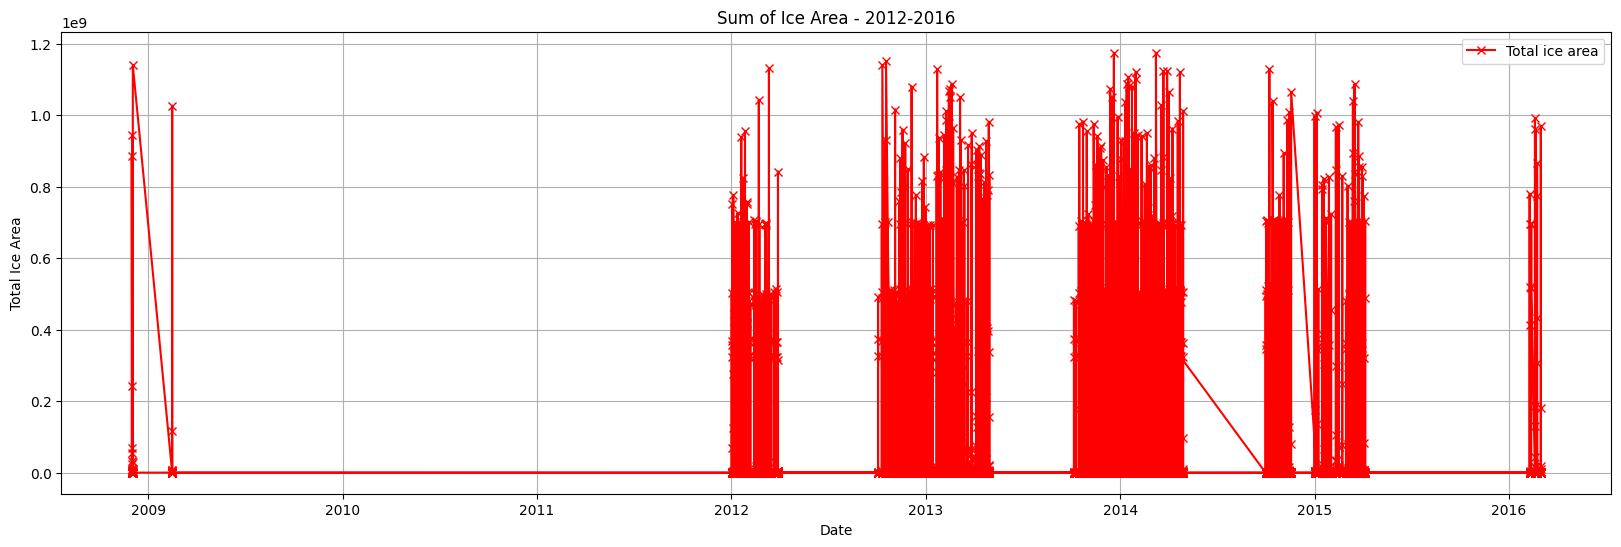

In [19]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(rswinter['date'], rswinter['area'], c= 'red', marker='x', label='Total ice area')
# plt.plot(dates, sums, marker='o', label='Total ice area')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
# plt.ylim(0,1.3e6)
plt.title('Sum of Ice Area - 2012-2016')
plt.legend()
plt.grid()
plt.show()

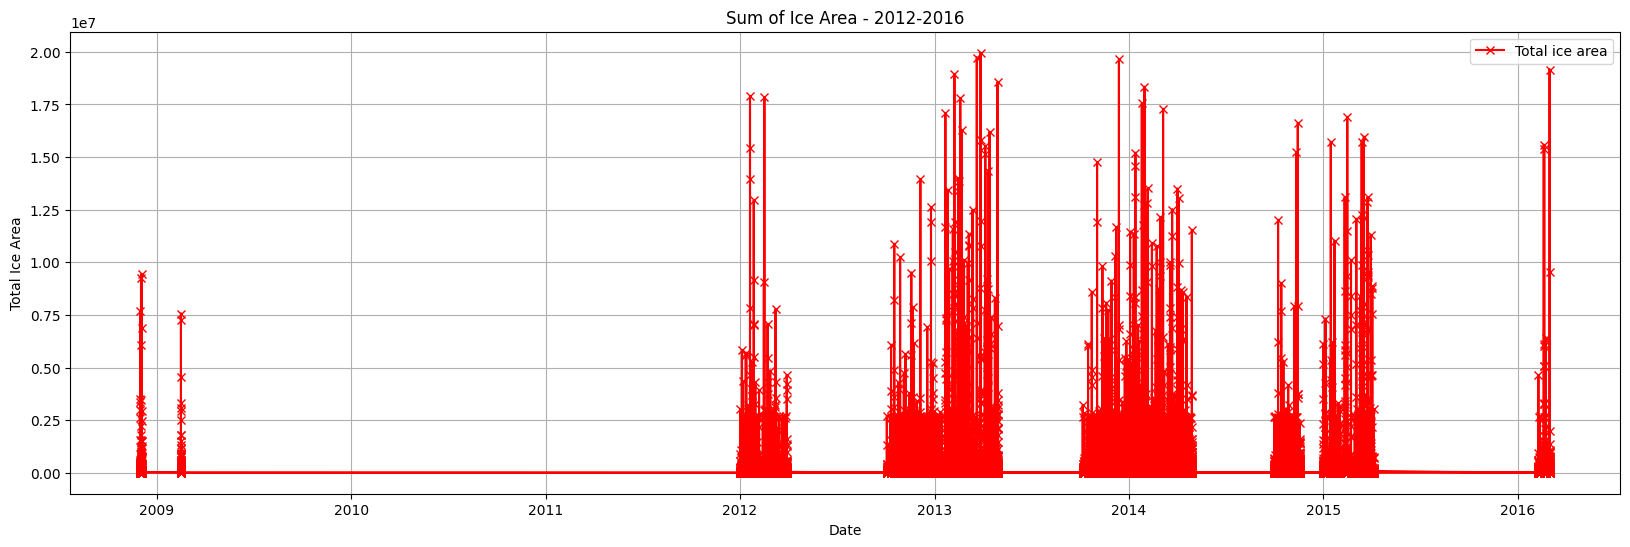

In [20]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(rsw['date'], rsw['area'], c= 'red', marker='x', label='Total ice area')
# plt.plot(dates, sums, marker='o', label='Total ice area')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
# plt.ylim(0,1.3e6)
plt.title('Sum of Ice Area - 2012-2016')
plt.legend()
plt.grid()
plt.show()

In [27]:
result = rsw.groupby(['date', 'value'])['area'].sum().reset_index()
print(result)

          date  value        area
0   2008-12-01    0.0   9810000.0
1   2008-12-01    1.0  49617500.0
2   2008-12-02    0.0   8672500.0
3   2008-12-02    1.0  99442500.0
4   2008-12-03    0.0   2202500.0
..         ...    ...         ...
747 2016-02-22    1.0  12925000.0
748 2016-02-23    0.0  21592500.0
749 2016-02-23    1.0  35187500.0
750 2016-03-01    0.0   8227500.0
751 2016-03-01    1.0  71212500.0

[752 rows x 3 columns]


In [28]:
ice_area = result[result['value'] == 1] 
print(ice_area)

          date  value        area
1   2008-12-01    1.0  49617500.0
3   2008-12-02    1.0  99442500.0
5   2008-12-03    1.0  40552500.0
7   2009-02-15    1.0  62160000.0
9   2012-01-02    1.0   1140000.0
..         ...    ...         ...
743 2016-02-19    1.0  52227500.0
745 2016-02-20    1.0  65177500.0
747 2016-02-22    1.0  12925000.0
749 2016-02-23    1.0  35187500.0
751 2016-03-01    1.0  71212500.0

[376 rows x 3 columns]


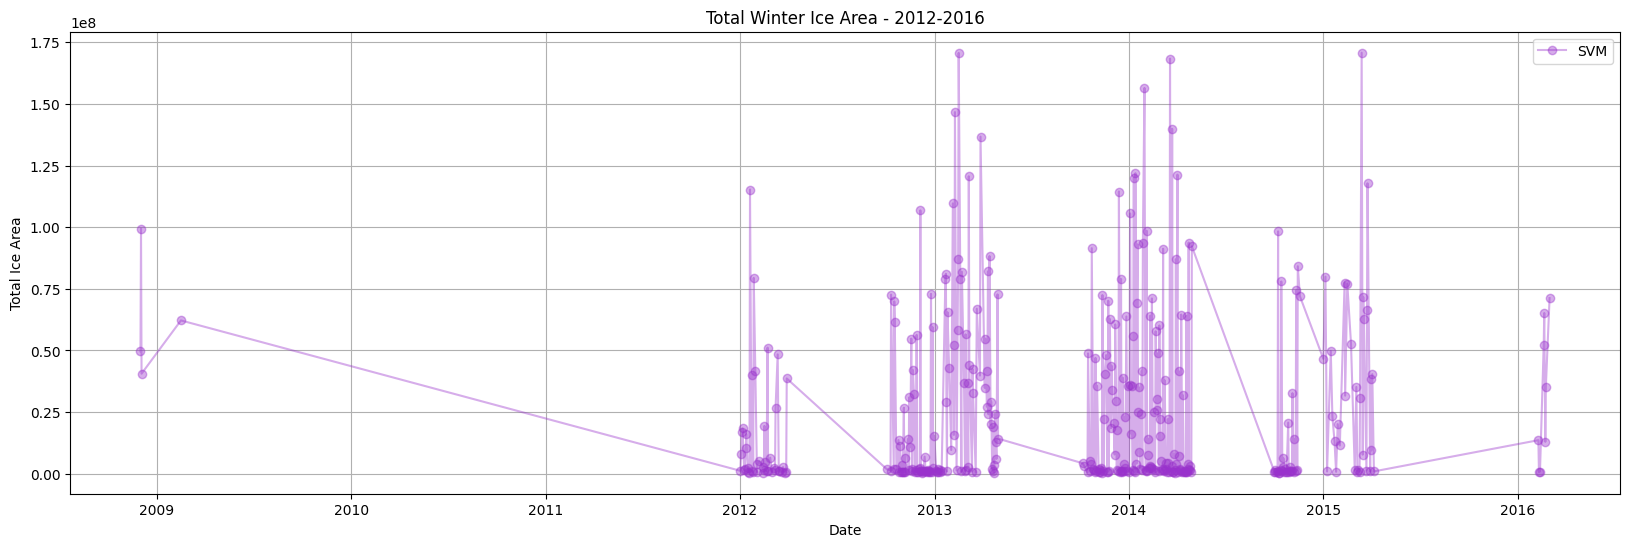

In [29]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(ice_area['date'], ice_area['area'], c='darkorchid', marker='o', alpha=0.4, label='SVM')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
# plt.ylim(0,1.3e6)
plt.title('Total Winter Ice Area - 2012-2016')
plt.legend()
plt.grid()
# plt.savefig("C:/Users/jullian.williams/Desktop/plots.png", bbox_inches="tight", pad_inches=0.3, transparent=True)
plt.show()

## Summer

In [17]:
input_dir = "C:/Users/jullian.williams/Desktop/Summer/"

dataframes_ = []

# Loop through all .tif files in the input directory
for subdir, _, files in os.walk(input_dir):
    for filename in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if filename.endswith(('.tif')):
            input_path = os.path.join(subdir, filename)
             
            with rio.open(input_path) as src_:
                profile = src_.profile  # Save metadata
                transform_ = src_.transform
                crs_=src_.crs
                b1_ = src_.read(1)
                
                def image_to_geodataframe(image_array, transform, crs):
            # Generate shapes (polygons) from the raster array
                    shapes_generator = shapes(image_array, transform=transform_)
                    
                    # Create a GeoDataFrame
                    geometries = []
                    values = []
                    for geom, value in shapes_generator:
                        geometries.append(shape(geom))
                        values.append(value)

                        name, ext = os.path.splitext(filename)
                        raftposition = 17
                        bfposition = 9
                
                        # Create the new file name
                        file_name = f"{filename[:raftposition]}"
                        fname = f"{file_name[bfposition:]}"
                                
                            
                    gdf = gpd.GeoDataFrame({'value': values, 'geometry': geometries, 'date':fname}, crs=crs_)
                    
                    return gdf 
                    
            gdf = image_to_geodataframe(b1_, transform=transform_, crs=crs_)


            gdf['date'] = pd.to_datetime(gdf['date'])
            gdf['area'] = gdf.geometry.area
            gdf['perimeter'] = gdf.geometry.length
            gdf['centroid'] = gdf.geometry.centroid
            # Extract latitude and longitude from centroids
            gdf['longitude'] = gdf.centroid.x
            gdf['latitude'] = gdf.centroid.y
            gdf.set_crs(epsg=32633, inplace=True)

            dataframes_.append(gdf)

In [18]:
summer = dataframes_

In [19]:
rssummer = pd.concat(summer, ignore_index=True)
print(rssummer)

        value                                           geometry       date  \
0         1.0  POLYGON ((498975 8559025, 498975 8558875, 4990... 2012-05-06   
1         1.0  POLYGON ((499475 8559025, 499475 8558975, 4993... 2012-05-06   
2         1.0  POLYGON ((499675 8558775, 499675 8558725, 4997... 2012-05-06   
3         1.0  POLYGON ((499175 8558675, 499175 8558625, 4992... 2012-05-06   
4         1.0  POLYGON ((500825 8558275, 500825 8558225, 5007... 2012-05-06   
...       ...                                                ...        ...   
635213    1.0  POLYGON ((505225 8531225, 505225 8531175, 5053... 2014-09-30   
635214    1.0  POLYGON ((506375 8531425, 506375 8531325, 5064... 2014-09-30   
635215    0.0  POLYGON ((498975 8559025, 498975 8558125, 4990... 2014-09-30   
635216    1.0  POLYGON ((510675 8531225, 510675 8531175, 5107... 2014-09-30   
635217    1.0  POLYGON ((512675 8531225, 512675 8531175, 5127... 2014-09-30   

                area  perimeter                    

In [20]:
rss = rssummer.drop(rssummer[rssummer['area'] >= 2e7].index) # Remove wrapper cells
print(rss)

        value                                           geometry       date  \
0         1.0  POLYGON ((498975 8559025, 498975 8558875, 4990... 2012-05-06   
1         1.0  POLYGON ((499475 8559025, 499475 8558975, 4993... 2012-05-06   
2         1.0  POLYGON ((499675 8558775, 499675 8558725, 4997... 2012-05-06   
3         1.0  POLYGON ((499175 8558675, 499175 8558625, 4992... 2012-05-06   
4         1.0  POLYGON ((500825 8558275, 500825 8558225, 5007... 2012-05-06   
...       ...                                                ...        ...   
635212    1.0  POLYGON ((503475 8531225, 503475 8531175, 5036... 2014-09-30   
635213    1.0  POLYGON ((505225 8531225, 505225 8531175, 5053... 2014-09-30   
635214    1.0  POLYGON ((506375 8531425, 506375 8531325, 5064... 2014-09-30   
635216    1.0  POLYGON ((510675 8531225, 510675 8531175, 5107... 2014-09-30   
635217    1.0  POLYGON ((512675 8531225, 512675 8531175, 5127... 2014-09-30   

            area  perimeter                        

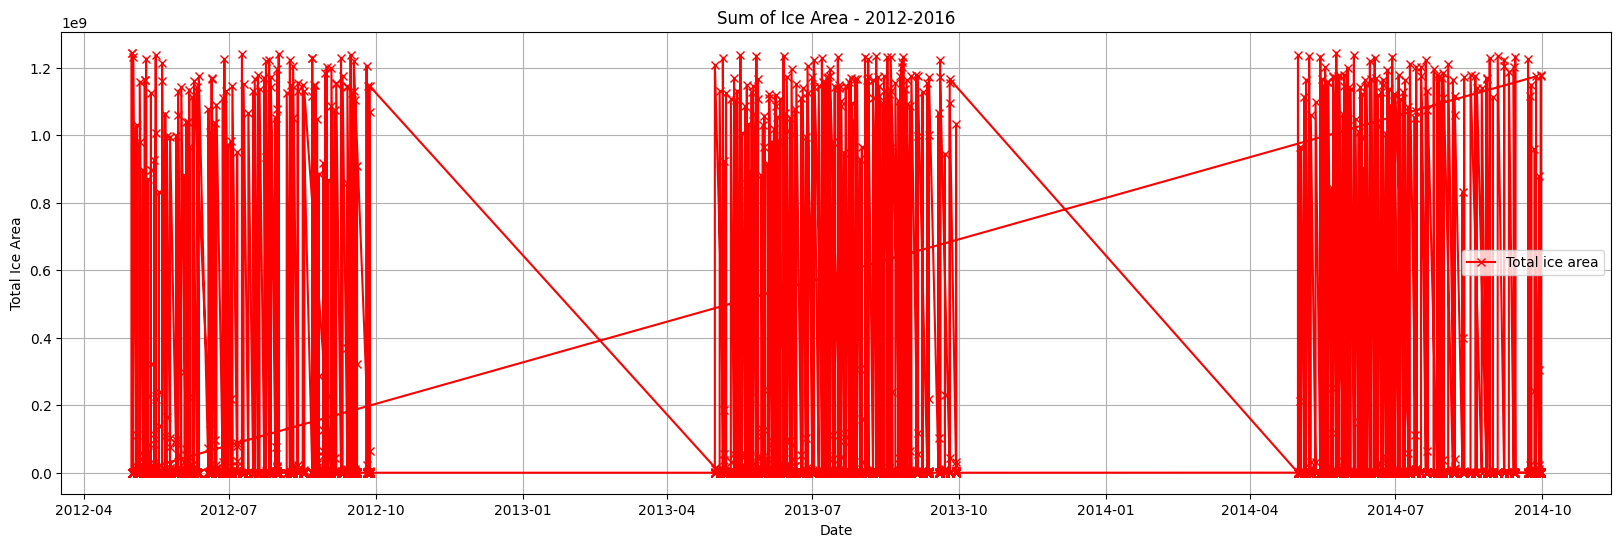

In [25]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(rssummer['date'], rssummer['area'], c= 'red', marker='x', label='Total ice area')
# plt.plot(dates, sums, marker='o', label='Total ice area')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
# plt.ylim(0,1.3e6)
plt.title('Sum of Ice Area - 2012-2016')
plt.legend()
plt.grid()
plt.show()

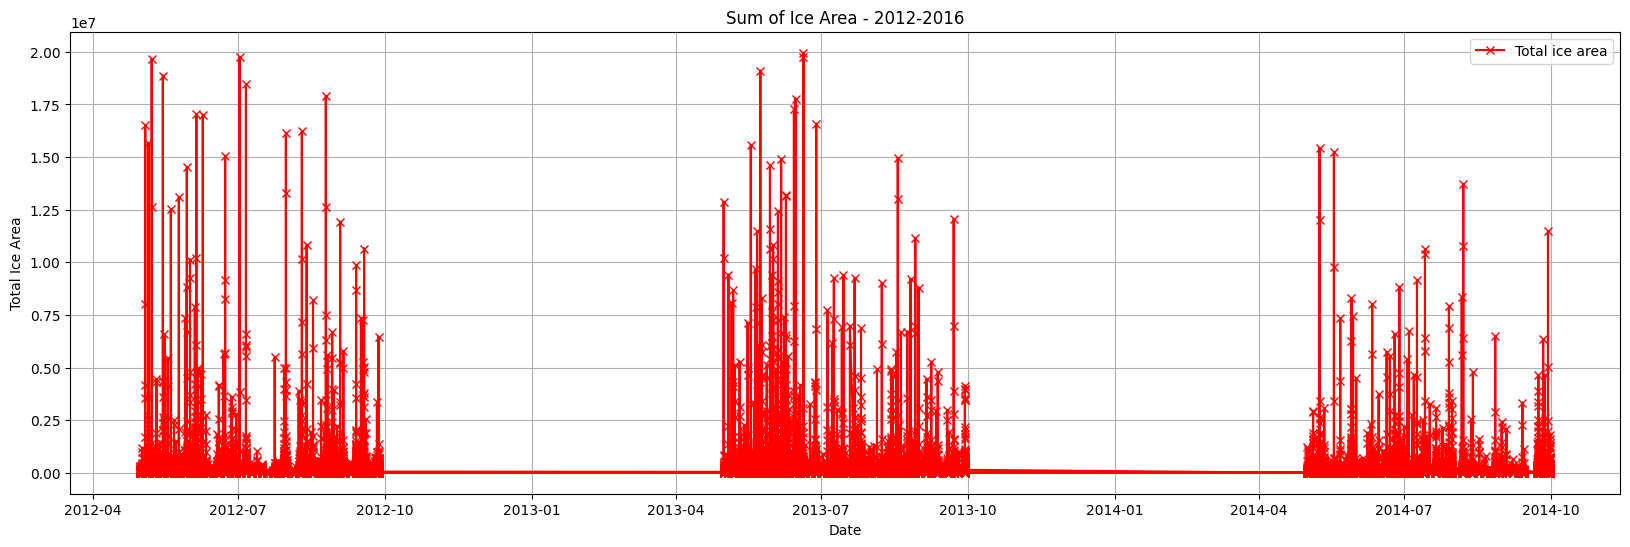

In [26]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(rss['date'], rss['area'], c= 'red', marker='x', label='Total ice area')
# plt.plot(dates, sums, marker='o', label='Total ice area')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
# plt.ylim(0,1.3e6)
plt.title('Sum of Ice Area - 2012-2016')
plt.legend()
plt.grid()
plt.show()

In [21]:
result_ = rss.groupby(['date', 'value'])['area'].sum().reset_index()
print(result_)

          date  value        area
0   2012-05-01    0.0  41185000.0
1   2012-05-02    0.0  32780000.0
2   2012-05-04    0.0  13797500.0
3   2012-05-04    1.0  54702500.0
4   2012-05-06    0.0  20147500.0
..         ...    ...         ...
495 2014-09-27    1.0  18025000.0
496 2014-09-29    0.0  21695000.0
497 2014-09-29    1.0  37110000.0
498 2014-09-30    0.0   1500000.0
499 2014-09-30    1.0  89635000.0

[500 rows x 3 columns]


In [22]:
ice_area_ = result_[result_['value'] == 1] 
print(ice_area_)

          date  value         area
3   2012-05-04    1.0   54702500.0
5   2012-05-06    1.0  111597500.0
7   2012-05-08    1.0   52832500.0
9   2012-05-09    1.0    2540000.0
12  2012-05-11    1.0   45520000.0
..         ...    ...          ...
491 2014-09-24    1.0   76642500.0
493 2014-09-26    1.0   47352500.0
495 2014-09-27    1.0   18025000.0
497 2014-09-29    1.0   37110000.0
499 2014-09-30    1.0   89635000.0

[243 rows x 3 columns]


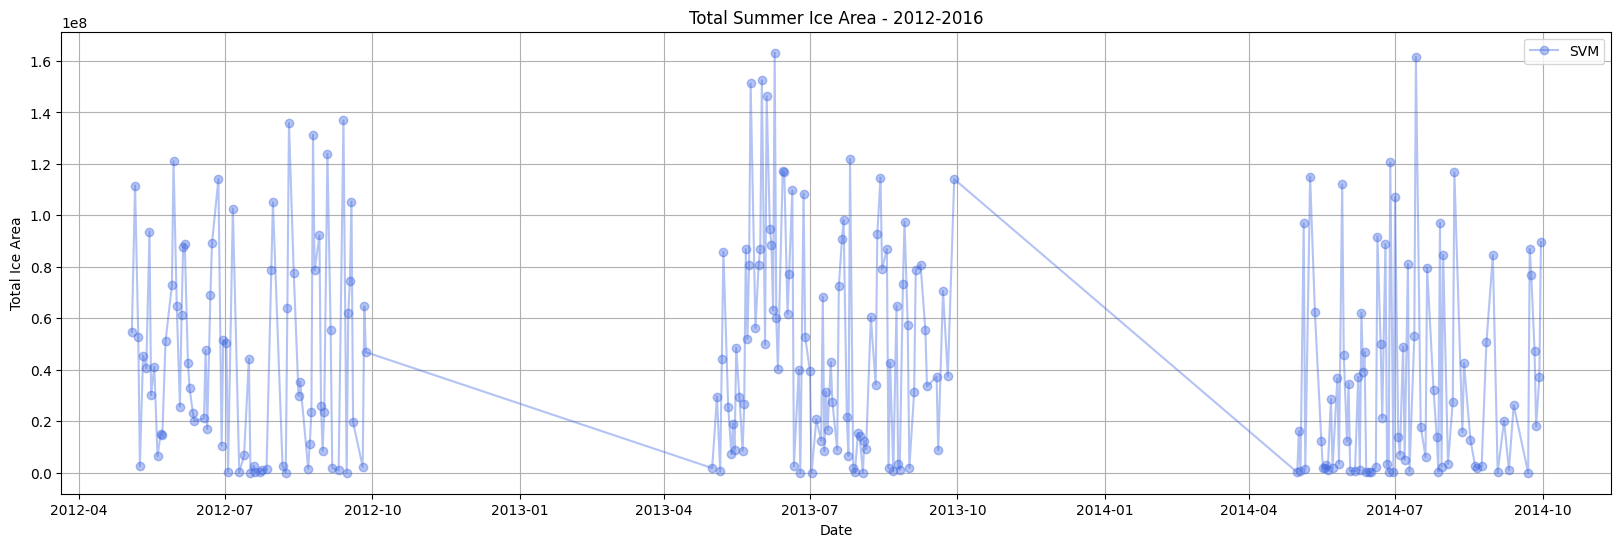

In [23]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(ice_area_['date'], ice_area_['area'], c='royalblue', marker='o', alpha=0.4, label='SVM')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
# plt.ylim(0,1.3e6)
plt.title('Total Summer Ice Area - 2012-2016')
plt.legend()
plt.grid()
# plt.savefig("C:/Users/jullian.williams/Desktop/plots.png", bbox_inches="tight", pad_inches=0.3, transparent=True)
plt.show()

# All seasons

## SVM

In [2]:
input_dir = "C:/Users/jullian.williams/Desktop/RS_12_16/"

df = []

# Loop through all .tif files in the input directory
for subdir, _, files in os.walk(input_dir):
    for filename in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if filename.endswith(('.tif')):
            input_path = os.path.join(subdir, filename)
             
            with rio.open(input_path) as src_:
                profile = src_.profile  # Save metadata
                transform_ = src_.transform
                crs_=src_.crs
                b1_ = src_.read(1)
                
                def image_to_geodataframe(image_array, transform, crs):
            # Generate shapes (polygons) from the raster array
                    shapes_generator = shapes(image_array, transform=transform_)
                    
                    # Create a GeoDataFrame
                    geometries = []
                    values = []
                    for geom, value in shapes_generator:
                        geometries.append(shape(geom))
                        values.append(value)

                        name, ext = os.path.splitext(filename)
                        raftposition = 17
                        bfposition = 9
                
                        # Create the new file name
                        file_name = f"{filename[:raftposition]}"
                        fname = f"{file_name[bfposition:]}"
                                
                            
                    gdf = gpd.GeoDataFrame({'value': values, 'geometry': geometries, 'date':fname}, crs=crs_)
                    
                    return gdf 
                    
            gdf = image_to_geodataframe(b1_, transform=transform_, crs=crs_)


            gdf['date'] = pd.to_datetime(gdf['date'])
            gdf['area'] = gdf.geometry.area
            gdf['perimeter'] = gdf.geometry.length
            gdf['centroid'] = gdf.geometry.centroid
            # Extract latitude and longitude from centroids
            gdf['longitude'] = gdf.centroid.x
            gdf['latitude'] = gdf.centroid.y
            gdf.set_crs(epsg=32633, inplace=True)

            df.append(gdf)

In [3]:
rs2 = pd.concat(df, ignore_index=True)
print(rs2)

         value                                           geometry       date  \
0          0.0  POLYGON ((500275 8558875, 500275 8558825, 5003... 2012-02-03   
1          1.0  POLYGON ((500825 8558275, 500825 8558225, 5007... 2012-02-03   
2          1.0  POLYGON ((501175 8558075, 501175 8558025, 5010... 2012-02-03   
3          0.0  POLYGON ((499575 8557625, 499575 8557575, 4996... 2012-02-03   
4          0.0  POLYGON ((500575 8557575, 500575 8557525, 5006... 2012-02-03   
...        ...                                                ...        ...   
1812786    1.0  POLYGON ((499425 8549075, 499425 8549025, 4993... 2016-03-01   
1812787    0.0  POLYGON ((510575 8531025, 510575 8530975, 5107... 2016-03-01   
1812788    0.0  POLYGON ((498975 8559025, 498975 8558275, 4990... 2016-03-01   
1812789    0.0  POLYGON ((511875 8531025, 511875 8530975, 5119... 2016-03-01   
1812790    1.0  POLYGON ((512925 8531075, 512925 8531025, 5128... 2016-03-01   

                area  perimeter        

In [4]:
rs2 = rs2.drop(rs2[rs2['area'] >= 2e7].index) # Remove wrapper cells
print(rs2)

         value                                           geometry       date  \
0          0.0  POLYGON ((500275 8558875, 500275 8558825, 5003... 2012-02-03   
1          1.0  POLYGON ((500825 8558275, 500825 8558225, 5007... 2012-02-03   
2          1.0  POLYGON ((501175 8558075, 501175 8558025, 5010... 2012-02-03   
3          0.0  POLYGON ((499575 8557625, 499575 8557575, 4996... 2012-02-03   
4          0.0  POLYGON ((500575 8557575, 500575 8557525, 5006... 2012-02-03   
...        ...                                                ...        ...   
1812784    0.0  POLYGON ((507675 8531025, 507675 8530975, 5077... 2016-03-01   
1812785    0.0  POLYGON ((507825 8531025, 507825 8530975, 5079... 2016-03-01   
1812787    0.0  POLYGON ((510575 8531025, 510575 8530975, 5107... 2016-03-01   
1812789    0.0  POLYGON ((511875 8531025, 511875 8530975, 5119... 2016-03-01   
1812790    1.0  POLYGON ((512925 8531075, 512925 8531025, 5128... 2016-03-01   

            area  perimeter            

In [5]:
rt = rs2.groupby(['date', 'value'])['area'].sum().reset_index()
print(rt)

           date  value        area
0    2012-01-02    0.0  14067500.0
1    2012-01-02    1.0   1140000.0
2    2012-01-03    0.0  24877500.0
3    2012-01-03    1.0   7987500.0
4    2012-01-05    0.0  17307500.0
...         ...    ...         ...
1239 2016-02-22    1.0  12925000.0
1240 2016-02-23    0.0  21592500.0
1241 2016-02-23    1.0  35187500.0
1242 2016-03-01    0.0   8227500.0
1243 2016-03-01    1.0  71212500.0

[1244 rows x 3 columns]


In [6]:
iceara = rt[rt['value'] == 1] 
print(iceara)

           date  value        area
1    2012-01-02    1.0   1140000.0
3    2012-01-03    1.0   7987500.0
5    2012-01-05    1.0  16722500.0
7    2012-01-06    1.0  18317500.0
9    2012-01-09    1.0   1452500.0
...         ...    ...         ...
1235 2016-02-19    1.0  52227500.0
1237 2016-02-20    1.0  65177500.0
1239 2016-02-22    1.0  12925000.0
1241 2016-02-23    1.0  35187500.0
1243 2016-03-01    1.0  71212500.0

[615 rows x 3 columns]


In [7]:
r = rs2.groupby(['date'])['area'].sum().reset_index()
print(r)

          date        area
0   2012-01-02  15207500.0
1   2012-01-03  32865000.0
2   2012-01-05  34030000.0
3   2012-01-06  27402500.0
4   2012-01-09  17010000.0
..         ...         ...
634 2016-02-19  61880000.0
635 2016-02-20  82295000.0
636 2016-02-22  20935000.0
637 2016-02-23  56780000.0
638 2016-03-01  79440000.0

[639 rows x 2 columns]


In [8]:
xm = pd.merge(iceara,r, on='date',how='outer').fillna(0)
xm['perc'] = (xm['area_x']/xm['area_y'])*100
xm['julian'] = xm['date'].dt.strftime('%j')
print(xm)

          date  value      area_x      area_y       perc julian
0   2012-01-02    1.0   1140000.0  15207500.0   7.496301    002
1   2012-01-03    1.0   7987500.0  32865000.0  24.303971    003
2   2012-01-05    1.0  16722500.0  34030000.0  49.140464    005
3   2012-01-06    1.0  18317500.0  27402500.0  66.846091    006
4   2012-01-09    1.0   1452500.0  17010000.0   8.539095    009
..         ...    ...         ...         ...        ...    ...
634 2016-02-19    1.0  52227500.0  61880000.0  84.401261    050
635 2016-02-20    1.0  65177500.0  82295000.0  79.199830    051
636 2016-02-22    1.0  12925000.0  20935000.0  61.738715    053
637 2016-02-23    1.0  35187500.0  56780000.0  61.971645    054
638 2016-03-01    1.0  71212500.0  79440000.0  89.643127    061

[639 rows x 6 columns]


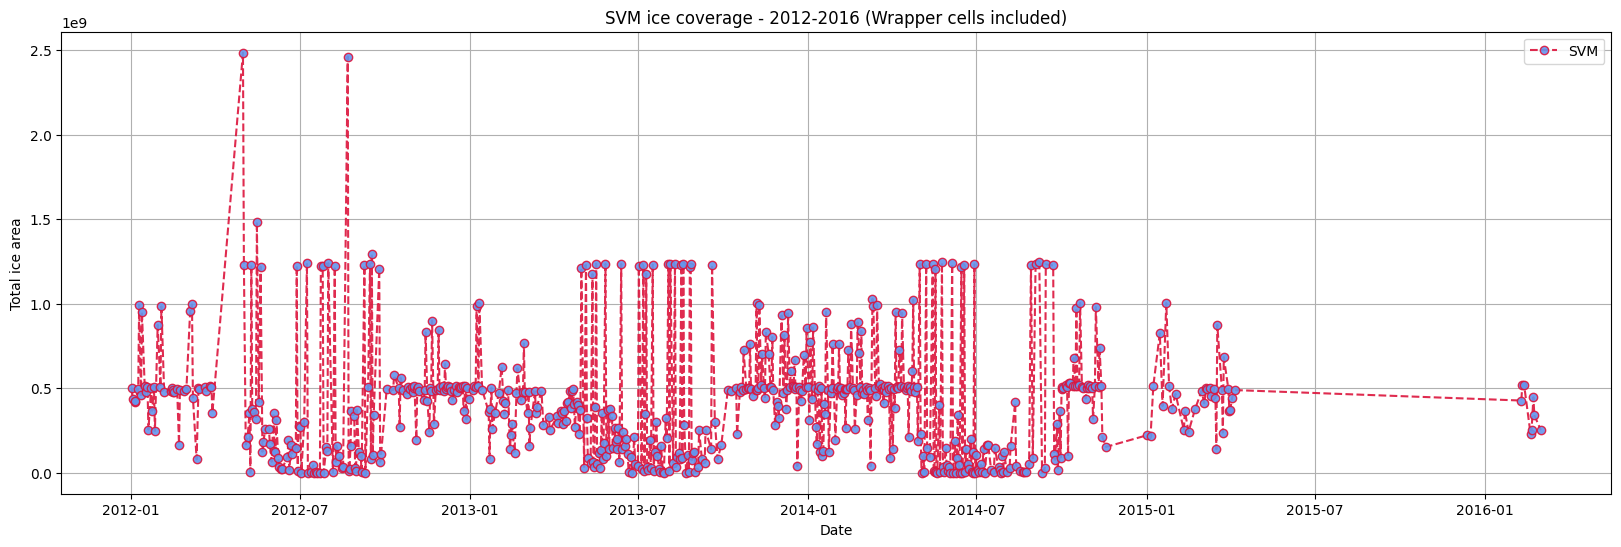

In [32]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(iceara['date'], iceara['area'], c='crimson', linestyle='--',markerfacecolor='cornflowerblue', marker='o', alpha=0.9, label='SVM')
plt.xlabel('Date')
plt.ylabel('Total ice area')
# plt.ylim(0,1.3e6)
plt.title('SVM ice coverage - 2012-2016 (Wrapper cells included)')
plt.legend()
plt.grid()
# plt.savefig("C:/Users/jullian.williams/Desktop/plots.png", bbox_inches="tight", pad_inches=0.3, transparent=True)
plt.show()

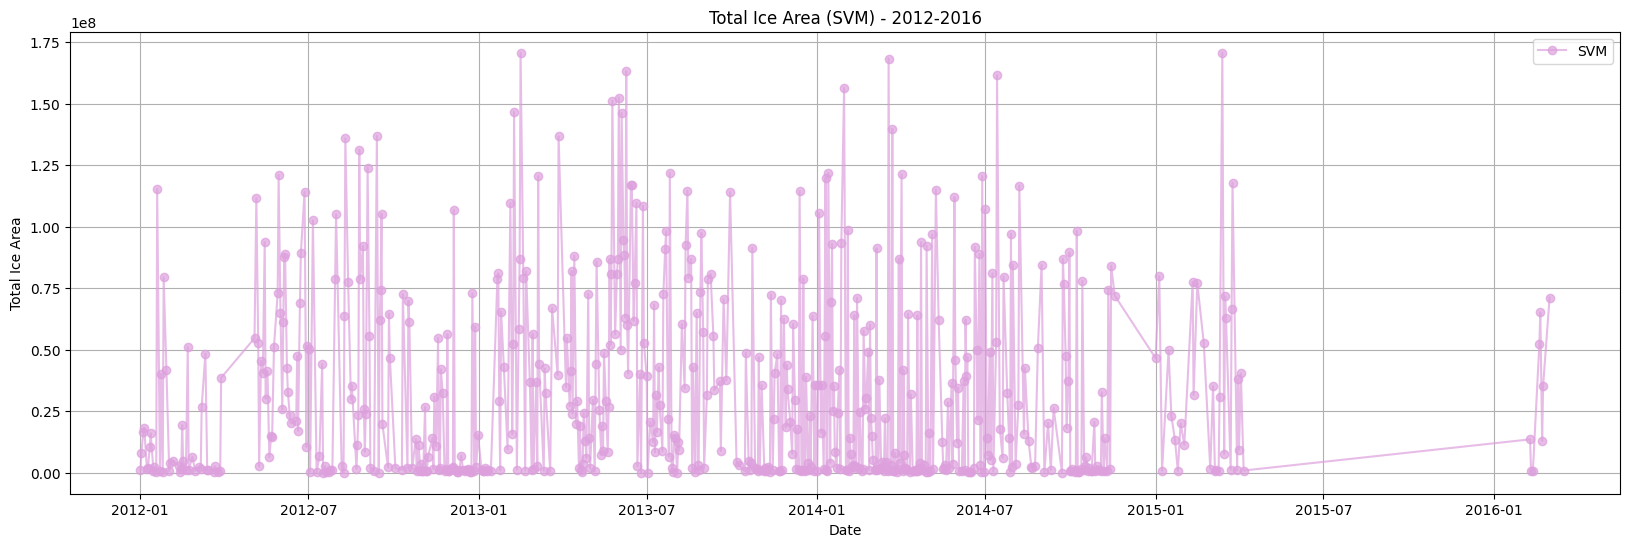

In [24]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(iceara['date'], iceara['area'], c='plum', marker='o', alpha=0.7, label='SVM')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
# plt.ylim(0,1.3e6)
plt.title('Total Ice Area (SVM) - 2012-2016')
plt.legend()
plt.grid()
# plt.savefig("C:/Users/jullian.williams/Desktop/plots.png", bbox_inches="tight", pad_inches=0.3, transparent=True)
plt.show()

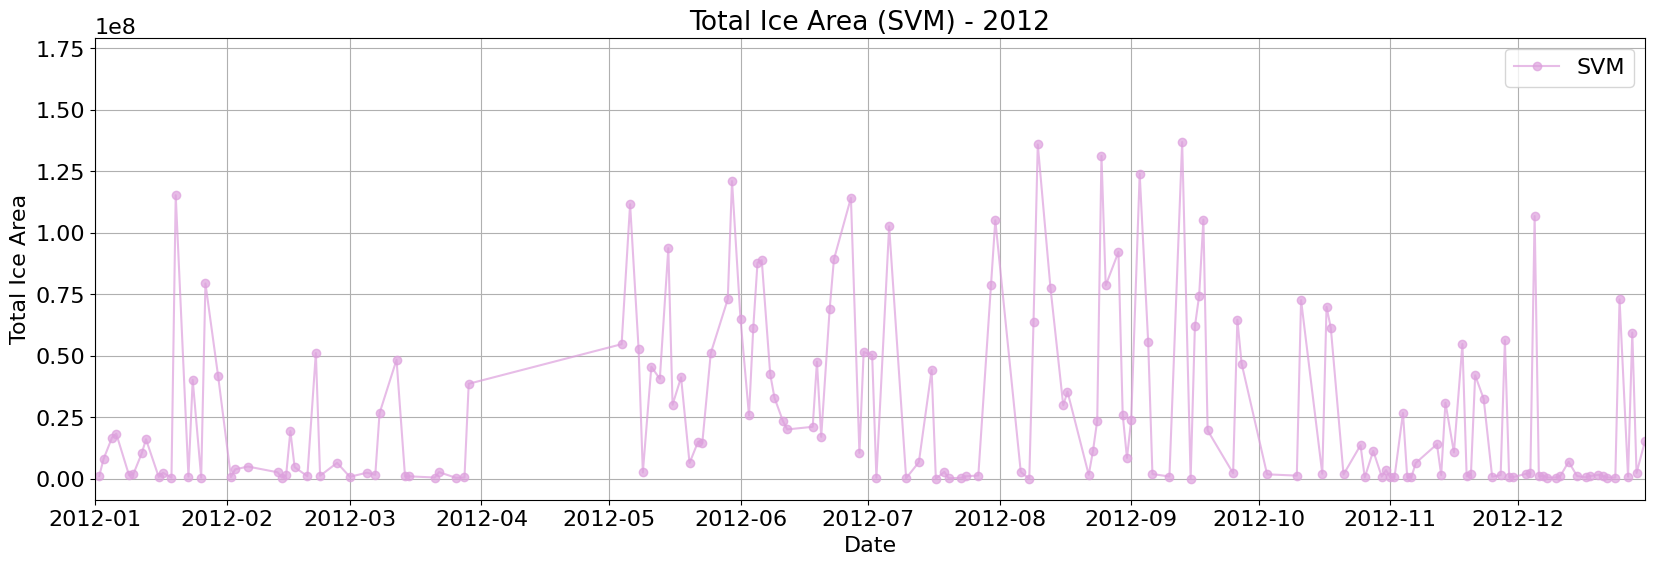

In [80]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(iceara['date'], iceara['area'], c='plum', marker='o', alpha=0.7, label='SVM')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
start_date = datetime(2012, 1, 1)
end_date = datetime(2012, 12, 31)
plt.xlim(start_date, end_date)
# plt.ylim(0,1.3e6)
plt.title('Total Ice Area (SVM) - 2012')
plt.legend()
plt.grid()
# plt.savefig("C:/Users/jullian.williams/Desktop/plots2a.png", bbox_inches="tight", pad_inches=0.3, transparent=True)
plt.show()

C:\Users\jullian.williams\AppData\Local\Temp\ipykernel_14748\4065546131.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


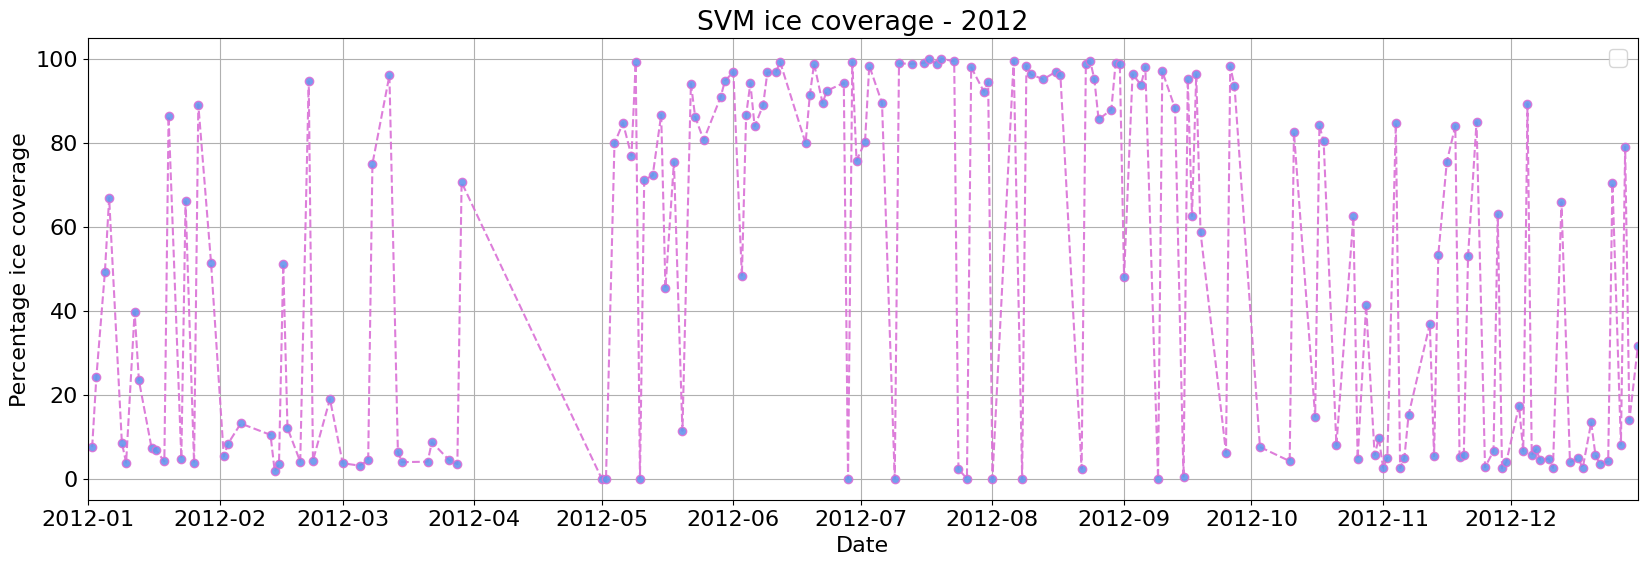

In [78]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(xm['date'], xm['perc'], c='orchid', linestyle='--', marker='o',markerfacecolor='cornflowerblue', alpha=0.9)
plt.xlabel('Date')
plt.ylabel('Percentage ice coverage')
start_date = datetime(2012, 1, 1)
end_date = datetime(2012, 12, 31) #(2015, 4, 30) 
plt.xlim(start_date, end_date)
# plt.ylim(0,1.3e6)
plt.title('SVM ice coverage - 2012')
plt.legend()
plt.grid()
# plt.savefig("C:/Users/jullian.williams/Desktop/plots.png", bbox_inches="tight", pad_inches=0.3, transparent=True)
plt.show()

#### Linear regression

In [113]:
print(xm['perc'].dtype)

float64


In [33]:
y = xm['area_y'].to_numpy()
stlist = xm['julian'].to_numpy()
x = [float(i) for i in stlist]
x = np.array(x)
print(x)

[  2.   3.   5.   6.   9.  10.  12.  13.  16.  17.  19.  20.  23.  24.
  26.  27.  30.  33.  34.  37.  44.  45.  46.  47.  48.  51.  53.  54.
  58.  61.  65.  67.  68.  72.  74.  75.  81.  82.  86.  88.  89. 122.
 123. 125. 127. 129. 130. 131. 132. 134. 136. 137. 139. 141. 143. 144.
 146. 150. 151. 153. 155. 156. 157. 158. 160. 161. 163. 164. 170. 171.
 172. 174. 175. 179. 180. 181. 182. 184. 185. 188. 191. 192. 195. 198.
 199. 201. 202. 205. 206. 208. 209. 212. 213. 214. 219. 221. 222. 223.
 226. 229. 230. 235. 236. 237. 238. 239. 242. 243. 244. 245. 247. 249.
 250. 253. 254. 257. 259. 260. 261. 262. 263. 269. 270. 271. 277. 284.
 285. 290. 291. 292. 295. 299. 300. 302. 304. 305. 306. 307. 309. 310.
 311. 312. 317. 318. 319. 321. 323. 324. 325. 326. 328. 330. 332. 333.
 334. 335. 338. 339. 340. 341. 342. 343. 345. 346. 348. 350. 352. 353.
 355. 356. 357. 359. 360. 362. 363. 364. 366.   4.   5.   7.   8.  10.
  11.  14.  21.  22.  23.  24.  25.  28.  32.  35.  37.  38.  39.  42.
  44. 

In [34]:
def calc_linreg_coef(x,y):
    if(np.size(x) !=np.size(y)):
        sys.exit("Length of x and y are not the same")

    #Number of observations
    n = np.size(x)

    sx = np.sum(x)
    sy = np.sum(y)
    
    sx2 = np.inner(x,x)
    sxy = np.inner(x,y)
    sy2 = np.inner(y,y)

    #Calculation of regression coefficients
    a1 = (n*sxy - sx*sy)/(n*sx2 - sx**2)
    a0 = (sy/n) - (a1*sx)/n

    r2 = ((n*sxy-sx*sy)/np.sqrt(n*sx2-sx**2)/np.sqrt(n*sy2-sy**2))**2;
          
    return (a0, a1, r2)
        

In [35]:
a0, a1, r2 = calc_linreg_coef(x,y)

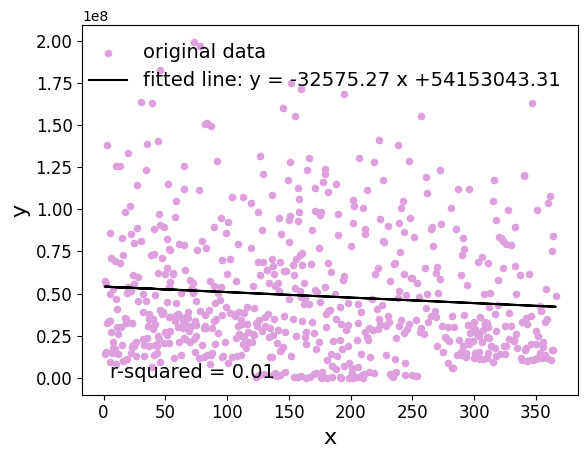

In [36]:
plt.scatter(x,y, c= 'plum', marker='o', s=20, label = 'original data')
y_pred = a0 + a1*x
plt.plot(x,y_pred, color = 'k', label = 'fitted line: y = %.2f x +%.2f'%(a1,a0)) 
plt.text(5,5,'r-squared = %.2f'%r2, fontsize = 14) 
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize =16)
plt.tick_params(axis='both', which='major', labelsize = 12)
plt.legend(loc='upper right', fontsize = 14, frameon=False)
plt.show()

#### Correlations and Fourier Analysis

In [189]:
mty = (rs2.groupby([rs2['date'].dt.month,'value']))['area'].mean().unstack()
mty

value,0.0,1.0
date,,
1,7144.611092,109890.917312
2,7040.426623,132916.247232
3,7380.371432,127258.966765
4,7340.332441,114513.881953
5,6351.123803,85256.388155
6,5759.972639,79433.881803
7,5638.199658,66483.650137
8,5767.248541,64039.893617
9,5536.208411,61651.701759


In [190]:
icemty = (rs2.groupby([rs2['date'].dt.month,'value']))['area'].mean().unstack()
icemty

value,0.0,1.0
date,,
1,7144.611092,109890.917312
2,7040.426623,132916.247232
3,7380.371432,127258.966765
4,7340.332441,114513.881953
5,6351.123803,85256.388155
6,5759.972639,79433.881803
7,5638.199658,66483.650137
8,5767.248541,64039.893617
9,5536.208411,61651.701759


In [191]:
iceyrl = (rs2.groupby([rs2['date'].dt.year,'value']))['area'].mean().unstack()
iceyrl

value,0.0,1.0
date,,
2012,6875.583505,78430.985253
2013,6688.581946,90672.283105
2014,7257.707923,73910.961531
2015,6369.596344,182238.205292
2016,6518.947247,125098.112270


In [192]:
cormty = mty.corr()
corimty = icemty.corr()
coriyrl = iceyrl.corr()
cormty

value,0.0,1.0
value,,
0.0,1.000000,0.546699
1.0,0.546699,1.000000


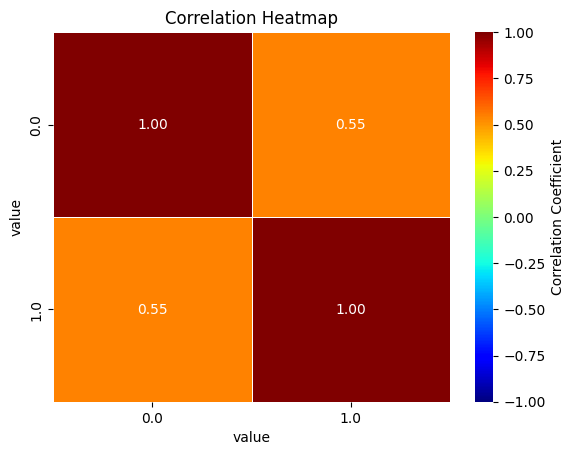

In [193]:
sns.heatmap(
    cormty, 
    annot=True, 
    fmt=".2f",  # Format for annotations:- decimal places
    cmap="jet",  # Custom color map
    linewidths=0.5,  # separation of blocks
    vmin = -1,
    vmax = 1,
    cbar_kws={'label': 'Correlation Coefficient'}  # Customize color bar
)
plt.title('Correlation Heatmap')
plt.show()

In [176]:
corimty

value,0.0,1.0
value,,
0.0,1.000000,0.546699
1.0,0.546699,1.000000


In [177]:
coriyrl

value,0.0,1.0
value,,
0.0,1.000000,-0.838329
1.0,-0.838329,1.000000


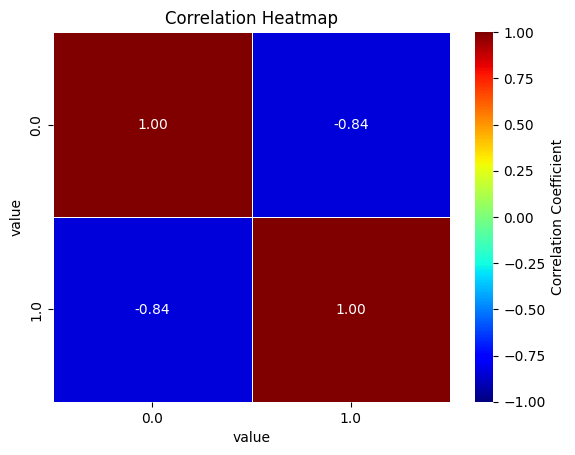

In [194]:
sns.heatmap(
    coriyrl, 
    annot=True, 
    fmt=".2f",  # Format for annotations:- decimal places
    cmap="jet",  # Custom color map
    linewidths=0.5,  # separation of blocks
    vmin = -1,
    vmax = 1,
    cbar_kws={'label': 'Correlation Coefficient'}  # Customize color bar
)
plt.title('Correlation Heatmap')
plt.show()

In [195]:
vt = (rs2.groupby([rs2['date'].dt.year,'value']))['area'].mean().unstack()

In [196]:
vt1 = vt[1]
vt1 = vt1.to_numpy()
vt1

array([ 78430.98525284,  90672.28310451,  73910.96153132, 182238.20529168,
       125098.11227024])

In [197]:
vtft = fft(vt1)
vtft

array([550350.5474506     -0.j        , -62121.32474815+96414.06546077j,
       -16976.48584504-82790.33638902j, -16976.48584504+82790.33638902j,
       -62121.32474815-96414.06546077j])

In [198]:
N = len(vtft)
n=np.arange(N)
sr=1/31556952 #placed in terms of seconds in year instead of # of years since hertz is in seconds but the plot looks virtually no different when run all the way through to the reconstruction plot
T = N/sr
freq = n/T

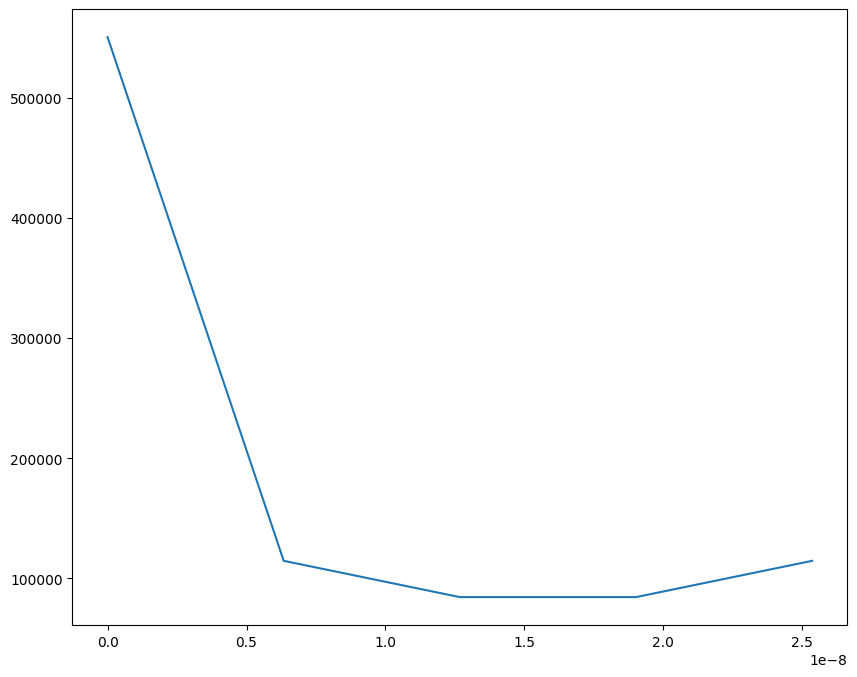

In [199]:
plt.figure(figsize=(10,8))
plt.plot(freq,np.abs(vtft)) #plot power spectrum as well

Text(0, 0.5, 'FFT amplitude')

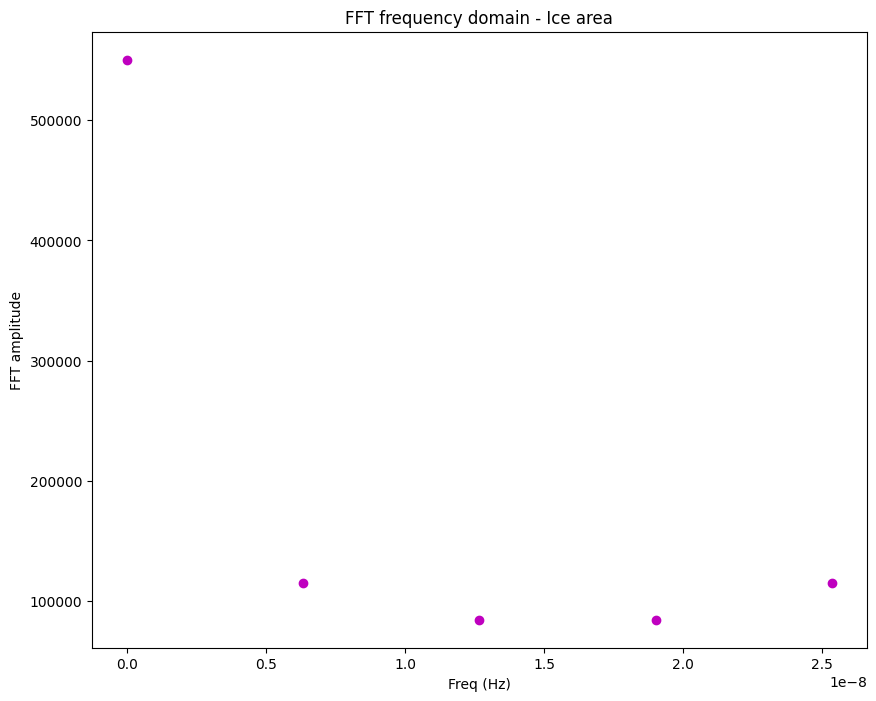

In [200]:
plt.figure(figsize=(10,8))
plt.plot(freq,np.abs(vtft),'mo') #plot power spectrum as well
plt.xlabel('Freq (Hz)')
plt.title('FFT frequency domain - Ice area')
plt.ylabel('FFT amplitude')

C:\Users\jullian.williams\AppData\Local\Temp\ipykernel_3552\511579271.py:11: RuntimeWarning: divide by zero encountered in divide
  np.allclose(peak_freq, 1./freq)


[]

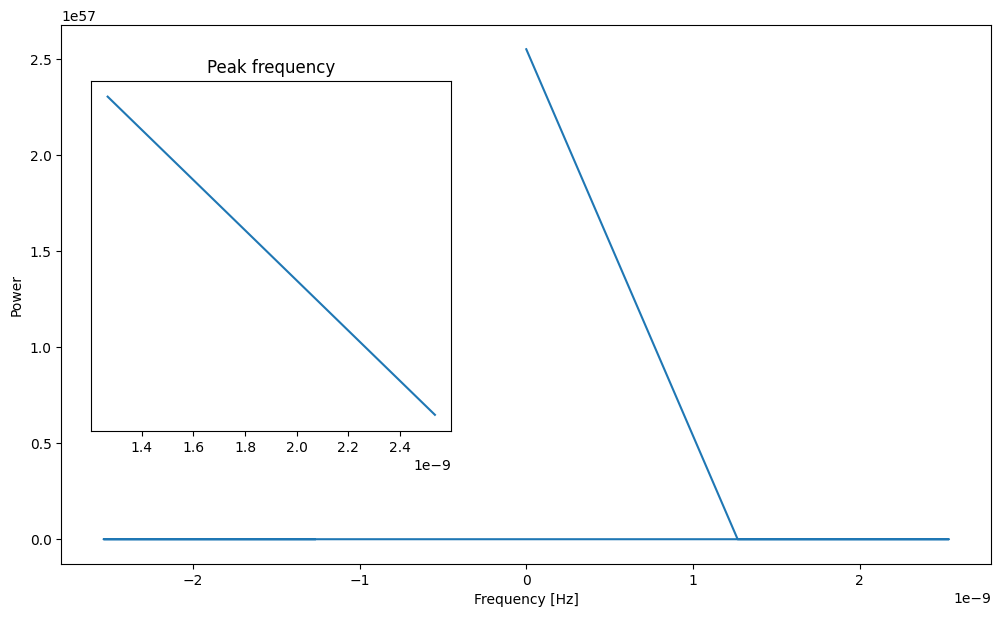

In [201]:
power = np.abs(vtft)**10
sample_freq = fftpack.fftfreq(vt1.size, d=T)
plt.figure(figsize=(12,7))
plt.plot(sample_freq, power)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')

pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
peak_freq = freqs[power[pos_mask].argmax()]
np.allclose(peak_freq, 1./freq)
axes = plt.axes([0.15, 0.3, 0.3, 0.5])
plt.title('Peak frequency')
plt.plot(freqs[:2], power[:2])
plt.setp(axes, yticks=[])

C:\Users\jullian.williams\.conda\envs\geospatial\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\jullian.williams\.conda\envs\geospatial\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


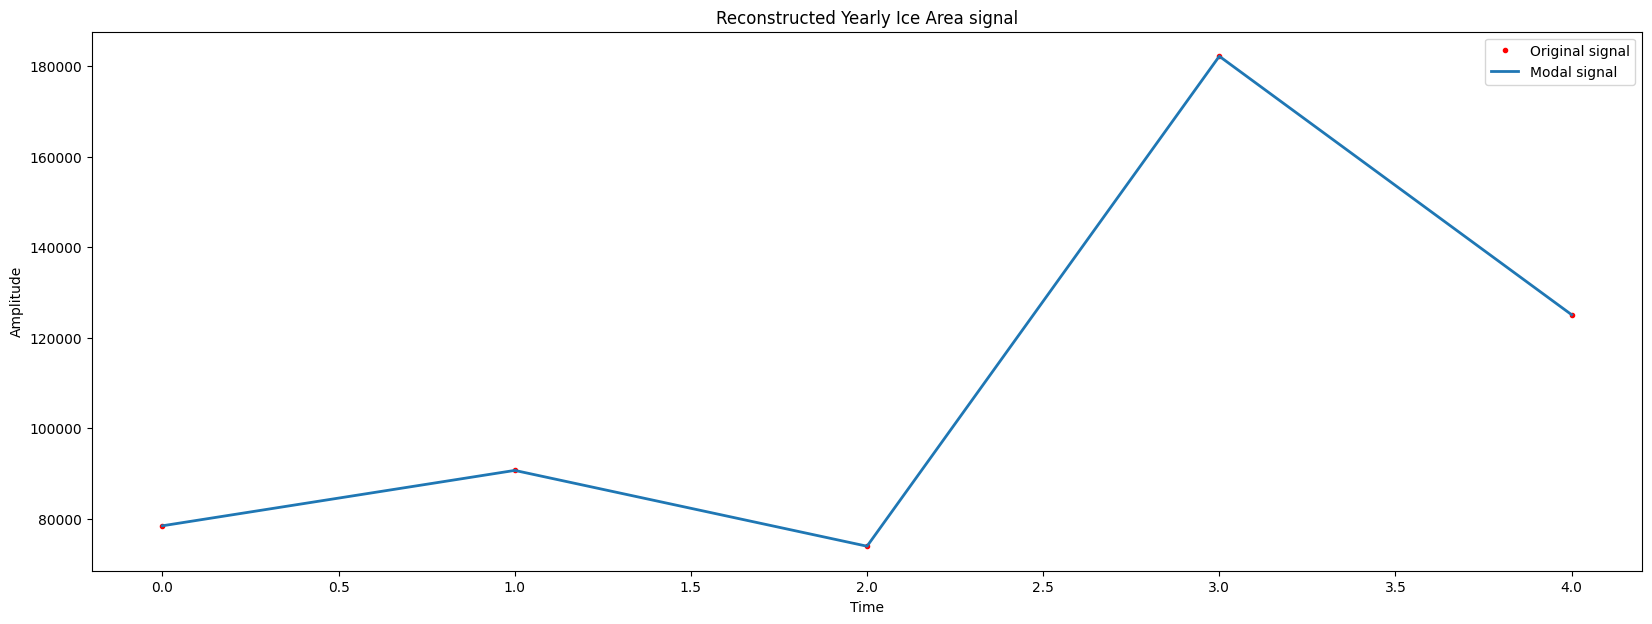

In [202]:
high_freq_fft = vtft.copy()
high_freq_fft[20::] = 0
filtered_sig = fftpack.ifft(high_freq_fft)

plt.figure(figsize=(20,7))
plt.plot(n, vt1, 'r.', label = 'Original signal')
plt.plot(n, filtered_sig, linewidth=2, label= 'Modal signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Reconstructed Yearly Ice Area signal')
plt.legend(loc='best')

## Gaussian 

In [111]:
input_dir = "C:/Users/jullian.williams/Desktop/z_16/"

df_ = []

# Loop through all .tif files in the input directory
for subdir, _, files in os.walk(input_dir):
    for filename in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if filename.endswith(('.tif')):
            input_path = os.path.join(subdir, filename)
             
            with rio.open(input_path) as src_:
                profile = src_.profile  # Save metadata
                transform_ = src_.transform
                crs_=src_.crs
                b1_ = src_.read(1)
                
                def image_to_geodataframe(image_array, transform, crs):
            # Generate shapes (polygons) from the raster array
                    shapes_generator = shapes(image_array, transform=transform_)
                    
                    # Create a GeoDataFrame
                    geometries = []
                    values = []
                    for geom, value in shapes_generator:
                        geometries.append(shape(geom))
                        values.append(value)
                        
                        name, ext = os.path.splitext(filename)
                        raftposition = 8
                    
                        # Create the new file name
                        file_name = f"{filename[:raftposition]}"
                                
                            
                    gdf = gpd.GeoDataFrame({'value': values, 'geometry': geometries, 'date':file_name}, crs=crs_)
                    
                    return gdf 
                    
            gdf = image_to_geodataframe(b1_, transform=transform_, crs=crs_)


            gdf['date'] = pd.to_datetime(gdf['date'])
            gdf['area'] = gdf.geometry.area
            gdf['perimeter'] = gdf.geometry.length
            gdf['centroid'] = gdf.geometry.centroid
            # Extract latitude and longitude from centroids
            gdf['longitude'] = gdf.centroid.x
            gdf['latitude'] = gdf.centroid.y
            gdf.set_crs(epsg=32633, inplace=True)

            df_.append(gdf)

In [112]:
rs2bin = pd.concat(df_, ignore_index=True)
print(rs2bin)

        value                                           geometry       date  \
0         1.0  POLYGON ((499625 8557925, 499625 8557875, 4995... 2012-01-02   
1         1.0  POLYGON ((522875 8557375, 522875 8557325, 5228... 2012-01-02   
2         1.0  POLYGON ((498975 8556975, 498975 8556825, 4990... 2012-01-02   
3         1.0  POLYGON ((523075 8556725, 523075 8556675, 5231... 2012-01-02   
4         1.0  POLYGON ((523175 8556675, 523175 8556625, 5232... 2012-01-02   
...       ...                                                ...        ...   
146202    1.0  POLYGON ((509525 8533525, 509525 8533475, 5094... 2016-03-03   
146203    0.0  POLYGON ((508975 8531125, 508975 8531075, 5089... 2016-03-03   
146204    0.0  POLYGON ((498975 8559025, 498975 8552125, 4990... 2016-03-03   
146205    1.0  POLYGON ((513525 8531075, 513525 8530975, 5135... 2016-03-03   
146206    1.0  POLYGON ((501975 8531125, 501975 8531075, 5019... 2016-03-03   

                area  perimeter                    

In [113]:
rs2bin = rs2bin.drop(rs2bin[rs2bin['area'] >= 2e7].index) # Remove wrapper cells
print(rs2bin)

        value                                           geometry       date  \
0         1.0  POLYGON ((499625 8557925, 499625 8557875, 4995... 2012-01-02   
1         1.0  POLYGON ((522875 8557375, 522875 8557325, 5228... 2012-01-02   
2         1.0  POLYGON ((498975 8556975, 498975 8556825, 4990... 2012-01-02   
3         1.0  POLYGON ((523075 8556725, 523075 8556675, 5231... 2012-01-02   
4         1.0  POLYGON ((523175 8556675, 523175 8556625, 5232... 2012-01-02   
...       ...                                                ...        ...   
146201    1.0  POLYGON ((512675 8531225, 512675 8530975, 5129... 2016-03-03   
146202    1.0  POLYGON ((509525 8533525, 509525 8533475, 5094... 2016-03-03   
146203    0.0  POLYGON ((508975 8531125, 508975 8531075, 5089... 2016-03-03   
146205    1.0  POLYGON ((513525 8531075, 513525 8530975, 5135... 2016-03-03   
146206    1.0  POLYGON ((501975 8531125, 501975 8531075, 5019... 2016-03-03   

             area  perimeter                       

In [114]:
rst = rs2bin.groupby(['date', 'value'])['area'].sum().reset_index()
print(rst)

           date  value        area
0    2012-01-02    1.0   2950000.0
1    2012-01-03    0.0   1585000.0
2    2012-01-03    1.0  35235000.0
3    2012-01-05    0.0    107500.0
4    2012-01-05    1.0  26002500.0
...         ...    ...         ...
1257 2016-02-29    1.0  56337500.0
1258 2016-03-01    0.0    602500.0
1259 2016-03-01    1.0  39085000.0
1260 2016-03-03    0.0     30000.0
1261 2016-03-03    1.0  23830000.0

[1262 rows x 3 columns]


In [115]:
iara = rst[rst['value'] == 1] 
print(iara)

           date  value        area
0    2012-01-02    1.0   2950000.0
2    2012-01-03    1.0  35235000.0
4    2012-01-05    1.0  26002500.0
6    2012-01-06    1.0  16237500.0
8    2012-01-09    1.0  66387500.0
...         ...    ...         ...
1253 2016-02-23    1.0  44572500.0
1255 2016-02-27    1.0  89947500.0
1257 2016-02-29    1.0  56337500.0
1259 2016-03-01    1.0  39085000.0
1261 2016-03-03    1.0  23830000.0

[743 rows x 3 columns]


In [116]:
i = rs2bin.groupby(['date'])['area'].sum().reset_index()
print(i)

          date        area
0   2012-01-02   2950000.0
1   2012-01-03  36820000.0
2   2012-01-05  26110000.0
3   2012-01-06  16390000.0
4   2012-01-09  67567500.0
..         ...         ...
739 2016-02-23  45065000.0
740 2016-02-27  94740000.0
741 2016-02-29  57190000.0
742 2016-03-01  39687500.0
743 2016-03-03  23860000.0

[744 rows x 2 columns]


In [117]:
mx = pd.merge(iara,i, on='date',how='outer').fillna(0)
mx['perc'] = (mx['area_x']/mx['area_y'])*100
mx['julian'] = mx['date'].dt.strftime('%j')
print(mx)

          date  value      area_x      area_y        perc julian
0   2012-01-02    1.0   2950000.0   2950000.0  100.000000    002
1   2012-01-03    1.0  35235000.0  36820000.0   95.695274    003
2   2012-01-05    1.0  26002500.0  26110000.0   99.588280    005
3   2012-01-06    1.0  16237500.0  16390000.0   99.069555    006
4   2012-01-09    1.0  66387500.0  67567500.0   98.253598    009
..         ...    ...         ...         ...         ...    ...
739 2016-02-23    1.0  44572500.0  45065000.0   98.907134    054
740 2016-02-27    1.0  89947500.0  94740000.0   94.941419    058
741 2016-02-29    1.0  56337500.0  57190000.0   98.509355    060
742 2016-03-01    1.0  39085000.0  39687500.0   98.481890    061
743 2016-03-03    1.0  23830000.0  23860000.0   99.874267    063

[744 rows x 6 columns]


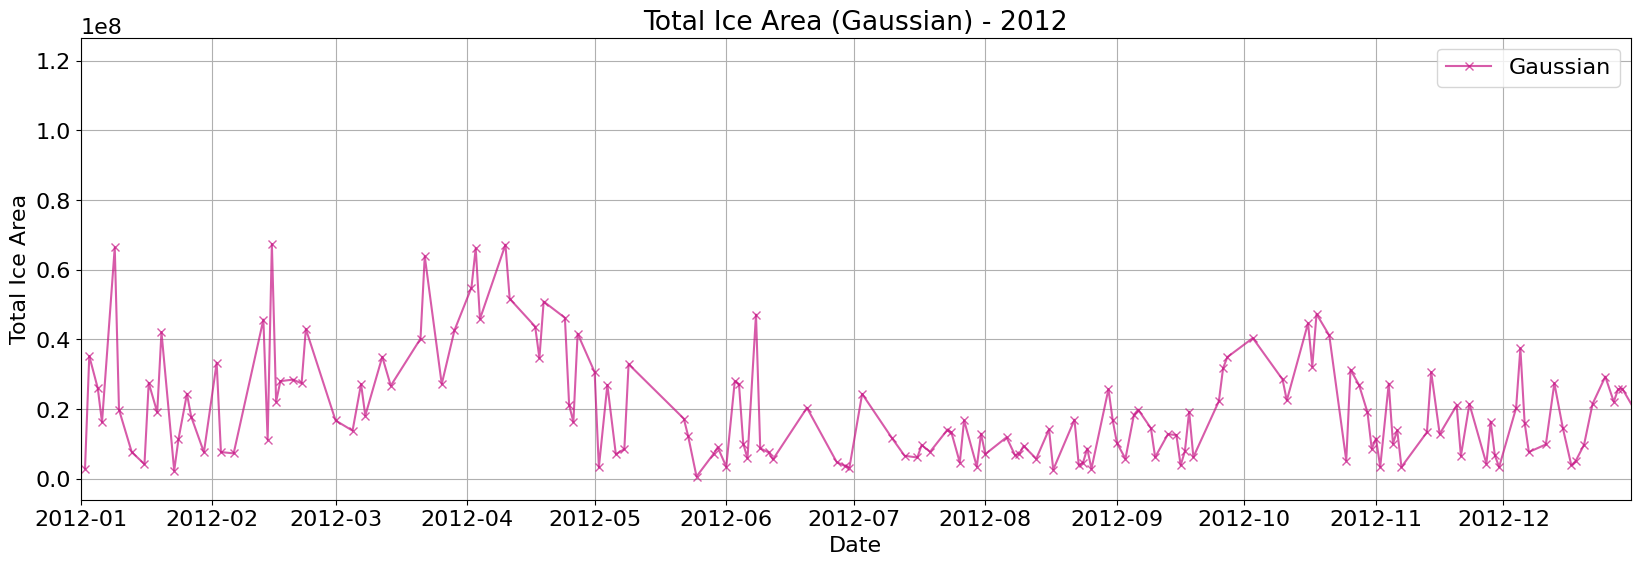

In [81]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(iara['date'], iara['area'], c='mediumvioletred', marker='x', alpha=0.7, label='Gaussian')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
start_date = datetime(2012, 1, 1)
end_date = datetime(2012, 12, 31) #(2015, 4, 30) 
plt.xlim(start_date, end_date)
# plt.ylim(0,1.3e6)
plt.title('Total Ice Area (Gaussian) - 2012')
plt.legend()
plt.grid()
# plt.savefig("C:/Users/jullian.williams/Desktop/plots2b.png", bbox_inches="tight", pad_inches=0.3, transparent=True)
plt.show()

C:\Users\jullian.williams\AppData\Local\Temp\ipykernel_14568\258419683.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


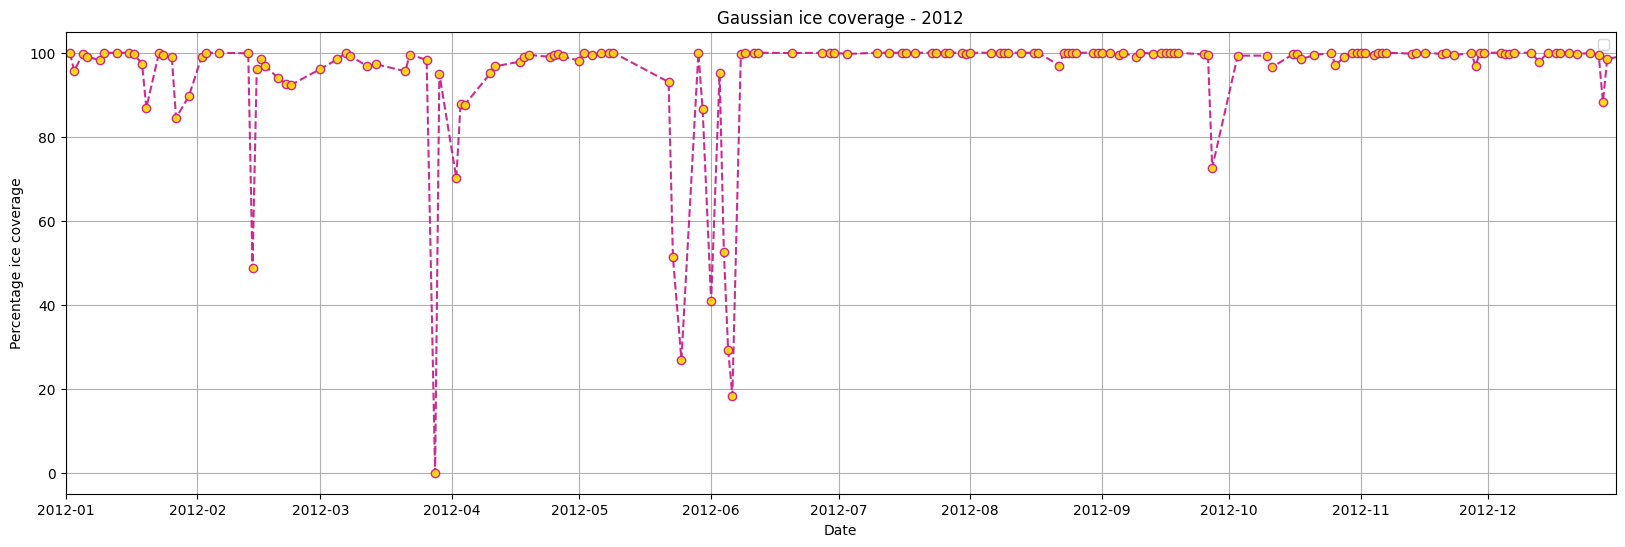

In [10]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(mx['date'], mx['perc'], c='mediumvioletred', linestyle='--', marker='o',markerfacecolor='gold', alpha=0.9)
plt.xlabel('Date')
plt.ylabel('Percentage ice coverage')
start_date = datetime(2012, 1, 1)
end_date = datetime(2012, 12, 31) #(2015, 4, 30) 
plt.xlim(start_date, end_date)
# plt.ylim(0,1.3e6)
plt.title('Gaussian ice coverage - 2012')
plt.legend()
plt.grid()
# plt.savefig("C:/Users/jullian.williams/Desktop/plots.png", bbox_inches="tight", pad_inches=0.3, transparent=True)
plt.show()

#### Linear regression

In [11]:
y = mx['area_y'].to_numpy()
stlist = mx['julian'].to_numpy()
x = [float(i) for i in stlist]
x = np.array(x)
print(x)

[  2.   3.   5.   6.   9.  10.  13.  16.  17.  19.  20.  23.  24.  26.
  27.  30.  33.  34.  37.  44.  45.  46.  47.  48.  51.  53.  54.  61.
  65.  67.  68.  72.  74.  81.  82.  86.  88.  89.  93.  94.  95. 101.
 102. 108. 109. 110. 115. 116. 117. 118. 122. 123. 125. 127. 129. 130.
 143. 144. 146. 150. 151. 153. 155. 156. 157. 158. 160. 161. 163. 164.
 172. 179. 181. 182. 185. 192. 195. 198. 199. 201. 205. 206. 208. 209.
 212. 213. 214. 219. 221. 222. 223. 226. 229. 230. 235. 236. 237. 238.
 239. 243. 244. 245. 247. 249. 250. 253. 254. 257. 259. 260. 261. 262.
 263. 269. 270. 271. 277. 284. 285. 290. 291. 292. 295. 299. 300. 302.
 304. 305. 306. 307. 309. 310. 311. 312. 318. 319. 321. 325. 326. 328.
 332. 333. 334. 335. 339. 340. 341. 342. 346. 348. 350. 352. 353. 355.
 357. 360. 362. 363. 364.   4.   5.  14.  15.  17.  18.  21.  22.  23.
  24.  25.  28.  32.  35.  37.  38.  39.  42.  44.  45.  46.  49.  51.
  52.  59.  60.  63.  64.  65.  71.  72.  73.  78.  80.  86.  87.  95.
  96. 

In [14]:
def calc_linreg_coef(x,y):
    if(np.size(x) !=np.size(y)):
        sys.exit("Length of x and y are not the same")

    #Number of observations
    n = np.size(x)

    sx = np.sum(x)
    sy = np.sum(y)
    
    sx2 = np.inner(x,x)
    sxy = np.inner(x,y)
    sy2 = np.inner(y,y)

    #Calculation of regression coefficients
    a1 = (n*sxy - sx*sy)/(n*sx2 - sx**2)
    a0 = (sy/n) - (a1*sx)/n

    r2 = ((n*sxy-sx*sy)/np.sqrt(n*sx2-sx**2)/np.sqrt(n*sy2-sy**2))**2;
          
    return (a0, a1, r2)
        

In [15]:
a0, a1, r2 = calc_linreg_coef(x,y)

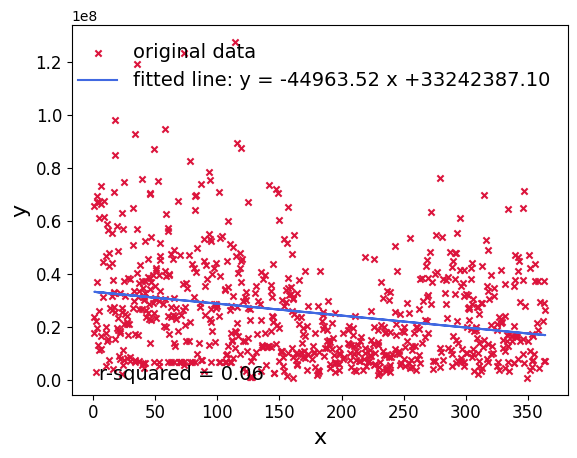

In [17]:
plt.scatter(x,y, c= 'crimson', marker='x', s=20, label = 'original data')
y_pred = a0 + a1*x
plt.plot(x,y_pred, color = 'royalblue', label = 'fitted line: y = %.2f x +%.2f'%(a1,a0)) 
plt.text(5,5,'r-squared = %.2f'%r2, fontsize = 14) 
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize =16)
plt.tick_params(axis='both', which='major', labelsize = 12)
plt.legend(loc='upper right', fontsize = 14, frameon=False)
plt.show()

#### Correlations and Fourier Analysis

In [179]:
mty = (rs2bin.groupby([rs2bin['date'].dt.month,'value']))['area'].mean().unstack()
mty

value,0.0,1.0
date,,
1,219941.285538,139284.636872
2,273325.688073,195695.280716
3,203965.517241,174076.005961
4,218965.306122,184218.923418
5,302553.272451,147586.690464
6,268213.058419,111780.907668
7,66992.187500,54895.456296
8,145758.426966,74545.146114
9,117041.666667,106446.136997


In [180]:
icemty = (rs2bin.groupby([rs2bin['date'].dt.month,'value']))['area'].mean().unstack()
icemty

value,0.0,1.0
date,,
1,219941.285538,139284.636872
2,273325.688073,195695.280716
3,203965.517241,174076.005961
4,218965.306122,184218.923418
5,302553.272451,147586.690464
6,268213.058419,111780.907668
7,66992.187500,54895.456296
8,145758.426966,74545.146114
9,117041.666667,106446.136997


In [181]:
iceyrl = (rs2bin.groupby([rs2bin['date'].dt.year,'value']))['area'].mean().unstack()
iceyrl

value,0.0,1.0
date,,
2012,201903.898459,95572.186548
2013,253799.070248,119029.432144
2014,130458.374628,119179.310345
2015,246090.965927,186166.936955
2016,129738.372093,136304.412865


In [183]:
cormty = mty.corr()
corimty = icemty.corr()
coriyrl = iceyrl.corr()
cormty

value,0.0,1.0
value,,
0.0,1.0000,0.6929
1.0,0.6929,1.0000


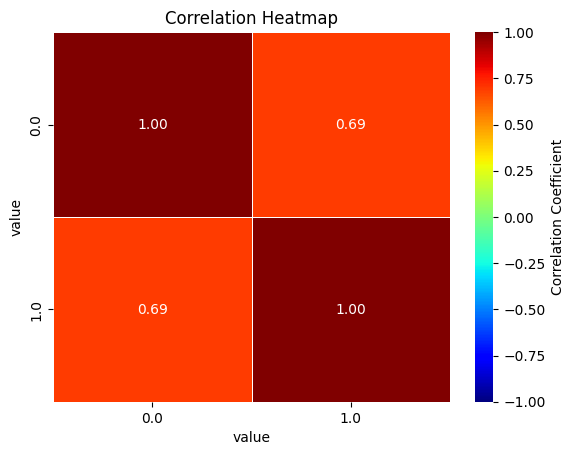

In [185]:
sns.heatmap(
    cormty, 
    annot=True, 
    fmt=".2f",  # Format for annotations:- decimal places
    cmap="jet",  # Custom color map
    linewidths=0.5,  # separation of blocks
    vmin = -1,
    vmax = 1,
    cbar_kws={'label': 'Correlation Coefficient'}  # Customize color bar
)
plt.title('Correlation Heatmap')
plt.show()

In [186]:
corimty

value,0.0,1.0
value,,
0.0,1.0000,0.6929
1.0,0.6929,1.0000


In [187]:
coriyrl

value,0.0,1.0
value,,
0.0,1.000000,0.280064
1.0,0.280064,1.000000


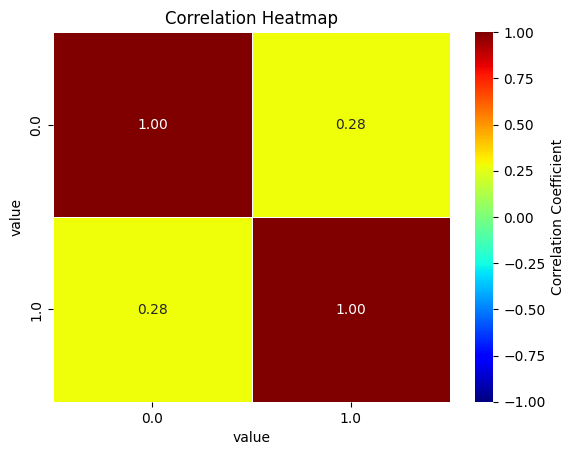

In [188]:
sns.heatmap(
    coriyrl, 
    annot=True, 
    fmt=".2f",  # Format for annotations:- decimal places
    cmap="jet",  # Custom color map
    linewidths=0.5,  # separation of blocks
    vmin = -1,
    vmax = 1,
    cbar_kws={'label': 'Correlation Coefficient'}  # Customize color bar
)
plt.title('Correlation Heatmap')
plt.show()

In [118]:
vt = (rs2bin.groupby([rs2bin['date'].dt.year,'value']))['area'].mean().unstack()

In [119]:
vt1 = vt[1]
vt1 = vt1.to_numpy()
vt1

array([ 95572.18654849, 119029.43214439, 119179.31034483, 186166.9369552 ,
       136304.41286462])

In [120]:
vtft = fft(vt1)
vtft

array([656252.27885753    -0.j        , -72555.61933896+55803.8219905j ,
       -16640.05371857-53555.03989795j, -16640.05371857+53555.03989795j,
       -72555.61933896-55803.8219905j ])

In [121]:
N = len(vtft)
n=np.arange(N)
sr=1/31556952 #placed in terms of seconds in year instead of # of years since hertz is in seconds but the plot looks virtually no different when run all the way through to the reconstruction plot
T = N/sr
freq = n/T

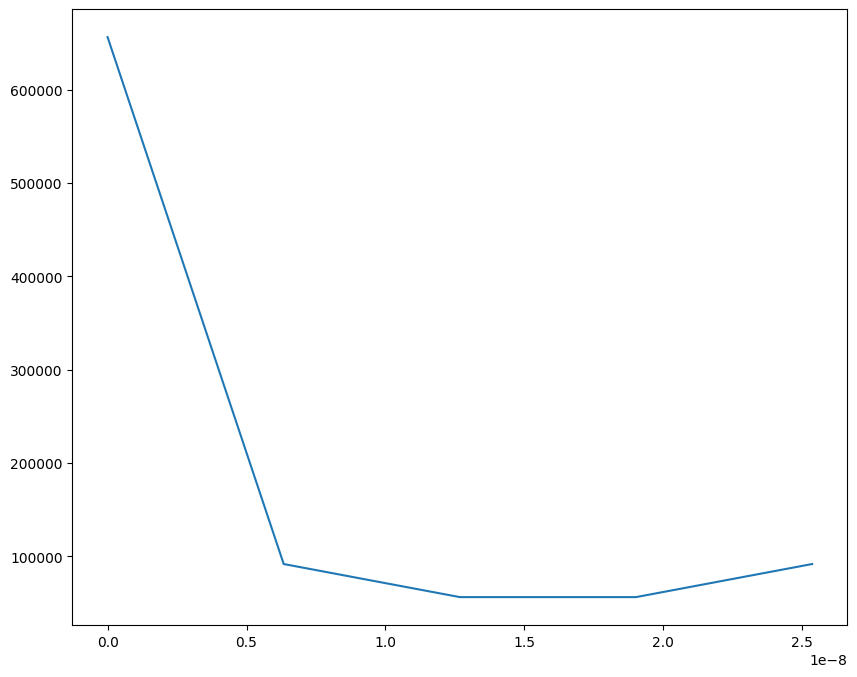

In [122]:
plt.figure(figsize=(10,8))
plt.plot(freq,np.abs(vtft)) #plot power spectrum as well

Text(0, 0.5, 'FFT amplitude')

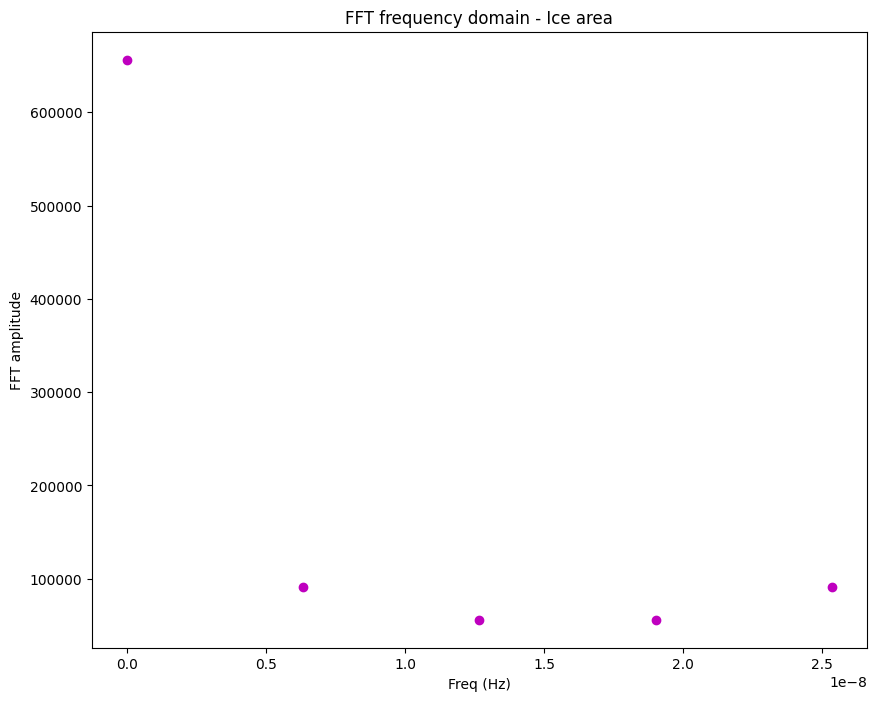

In [123]:
plt.figure(figsize=(10,8))
plt.plot(freq,np.abs(vtft),'mo') #plot power spectrum as well
plt.xlabel('Freq (Hz)')
plt.title('FFT frequency domain - Ice area')
plt.ylabel('FFT amplitude')

C:\Users\jullian.williams\AppData\Local\Temp\ipykernel_3552\511579271.py:11: RuntimeWarning: divide by zero encountered in divide
  np.allclose(peak_freq, 1./freq)


[]

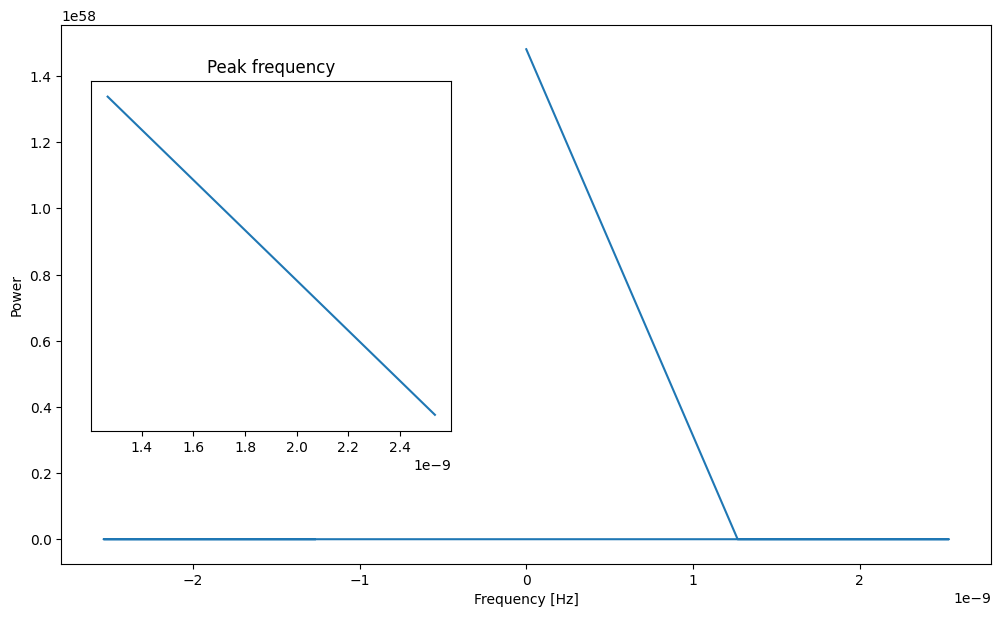

In [126]:
power = np.abs(vtft)**10
sample_freq = fftpack.fftfreq(vt1.size, d=T)
plt.figure(figsize=(12,7))
plt.plot(sample_freq, power)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')

pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
peak_freq = freqs[power[pos_mask].argmax()]
np.allclose(peak_freq, 1./freq)
axes = plt.axes([0.15, 0.3, 0.3, 0.5])
plt.title('Peak frequency')
plt.plot(freqs[:2], power[:2])
plt.setp(axes, yticks=[])

C:\Users\jullian.williams\.conda\envs\geospatial\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\jullian.williams\.conda\envs\geospatial\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


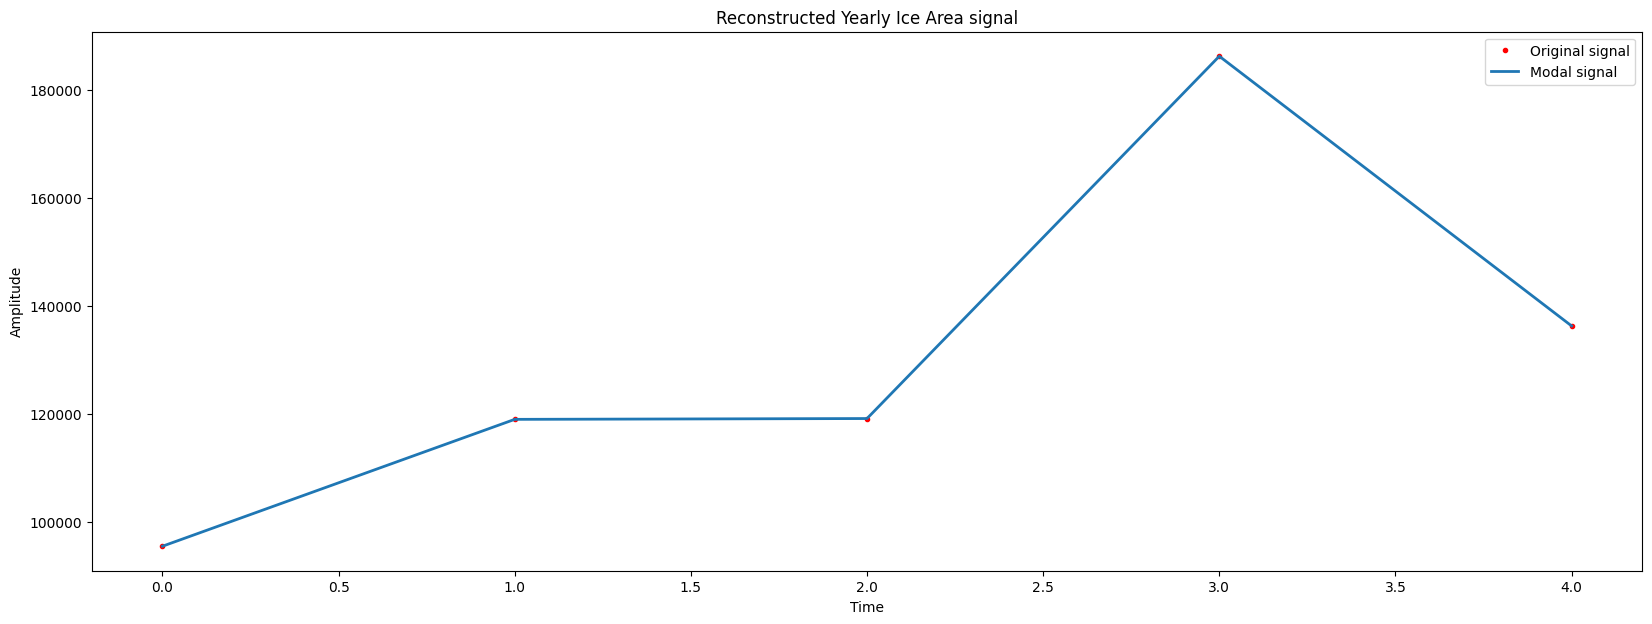

In [127]:
high_freq_fft = vtft.copy()
high_freq_fft[20::] = 0
filtered_sig = fftpack.ifft(high_freq_fft)

plt.figure(figsize=(20,7))
plt.plot(n, vt1, 'r.', label = 'Original signal')
plt.plot(n, filtered_sig, linewidth=2, label= 'Modal signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Reconstructed Yearly Ice Area signal')
plt.legend(loc='best')

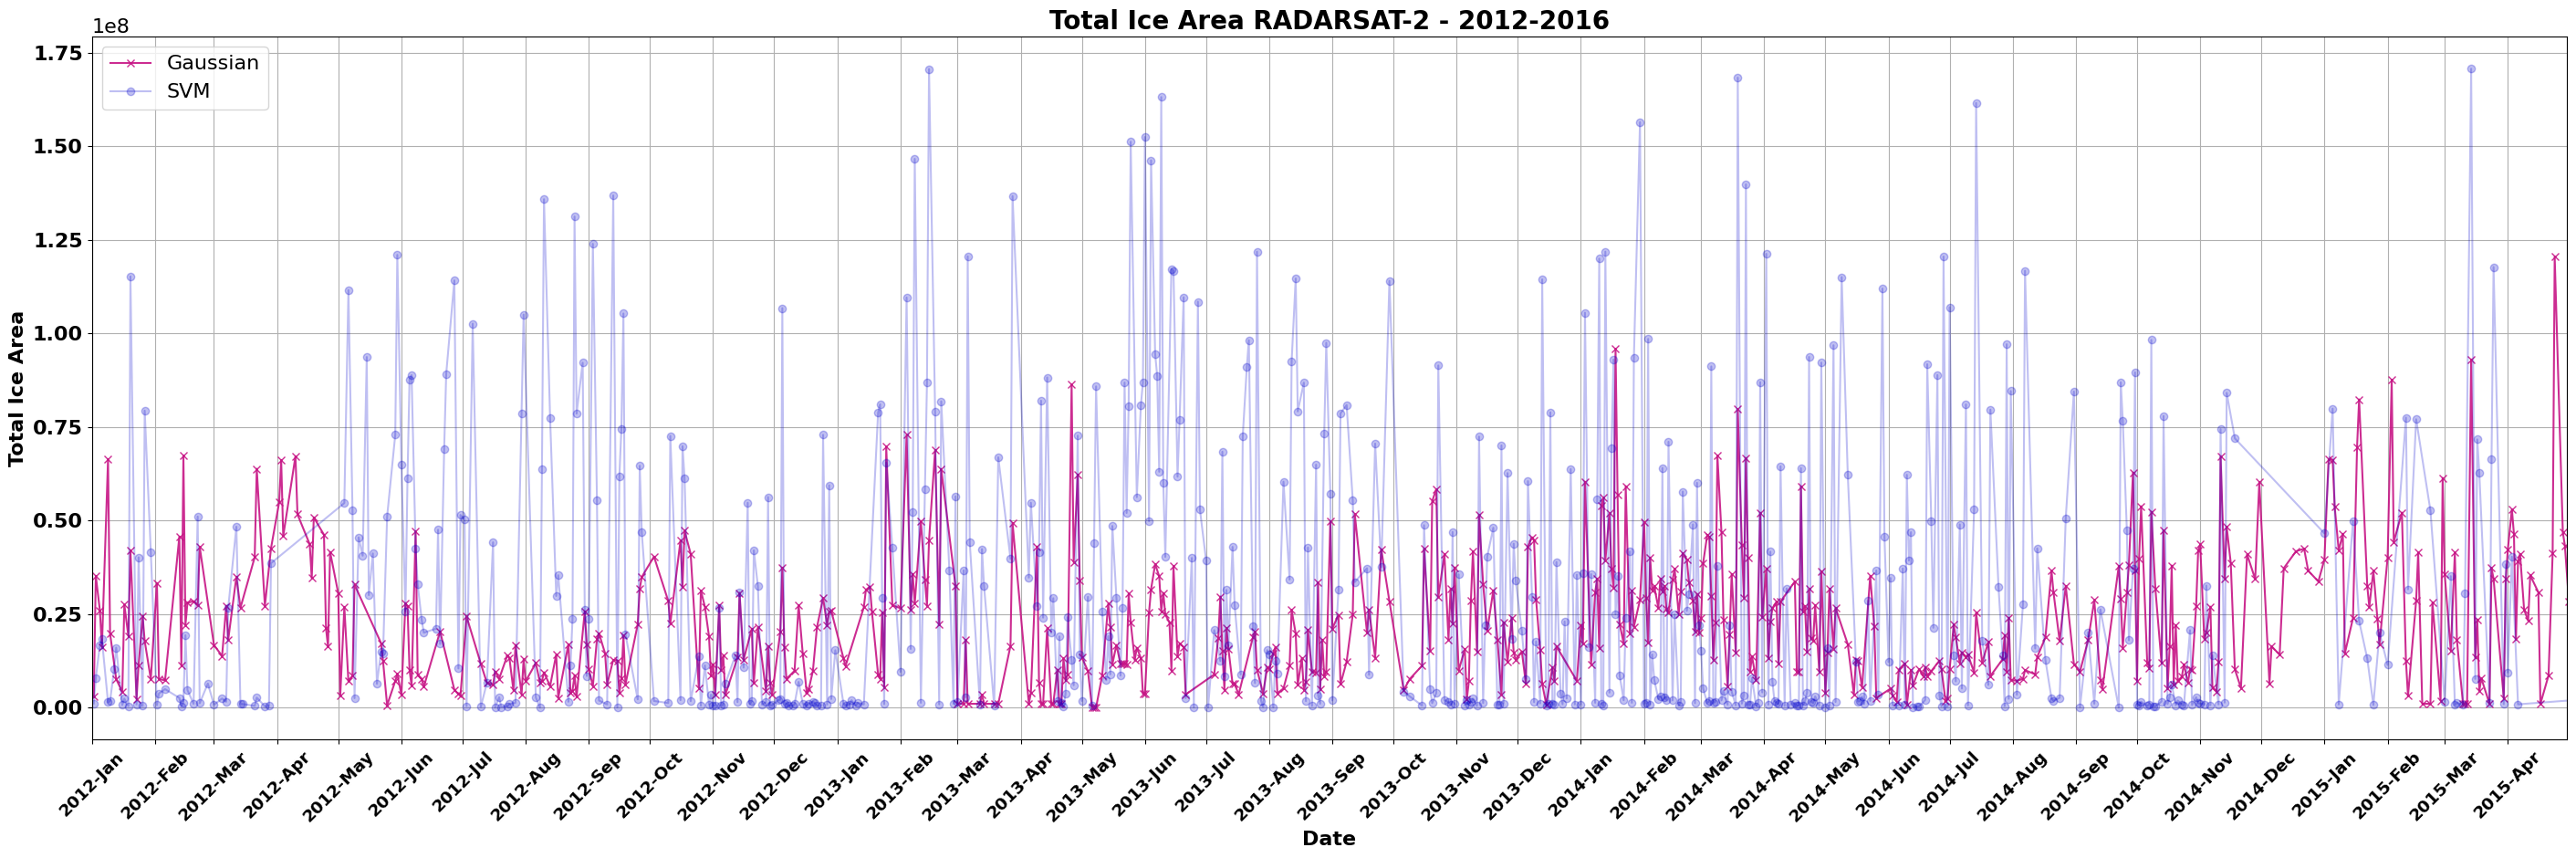

In [83]:
# Plot the results
plt.figure(figsize=(35, 10))
plt.rcParams.update({'font.size': 16})
plt.plot(iara['date'], iara['area'], c='mediumvioletred', marker='x', alpha=0.9, label='Gaussian')
plt.plot(iceara['date'], iceara['area'], c='mediumblue', marker='o', alpha=0.25, label='SVM')
plt.xlabel('Date', fontweight='bold')
plt.ylabel('Total Ice Area',fontweight='bold')
start_date = datetime(2012, 1, 1)
end_date = datetime(2015, 4, 30)
plt.xlim(start_date, end_date)
# plt.ylim(0,1.8e8)
dtFmt = mdates.DateFormatter('%Y-%b') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) 
# show every 12th tick on x axes
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45, fontweight='bold',  fontsize='small')
plt.yticks(fontweight='bold')
plt.title('Total Ice Area RADARSAT-2 - 2012-2016', fontweight='bold', fontsize=20)
plt.legend()
plt.grid()
# plt.savefig("C:/Users/jullian.williams/Desktop/plots.png", bbox_inches="tight", pad_inches=0.3, transparent=True)
plt.show()

# Principal Components

### Comparing ice area from SVM and Gaussian methods for 2012 - 2016

In [121]:
iara.head(2)

,date,value,area,julian
0,2012-01-02,1.0,2950000.0,2.0
2,2012-01-03,1.0,35235000.0,3.0


In [122]:
iara.info

<bound method DataFrame.info of            date  value        area  julian
0    2012-01-02    1.0   2950000.0     2.0
2    2012-01-03    1.0  35235000.0     3.0
4    2012-01-05    1.0  26002500.0     5.0
6    2012-01-06    1.0  16237500.0     6.0
8    2012-01-09    1.0  66387500.0     9.0
...         ...    ...         ...     ...
1253 2016-02-23    1.0  44572500.0    54.0
1255 2016-02-27    1.0  89947500.0    58.0
1257 2016-02-29    1.0  56337500.0    60.0
1259 2016-03-01    1.0  39085000.0    61.0
1261 2016-03-03    1.0  23830000.0    63.0

[743 rows x 4 columns]>

In [130]:
iceara.head(2)

,date,value,area
1,2012-01-02,1.0,1140000.0
3,2012-01-03,1.0,7987500.0


In [175]:
iceara.info

<bound method DataFrame.info of            date  value        area
1    2012-01-02    1.0   1140000.0
3    2012-01-03    1.0   7987500.0
5    2012-01-05    1.0  16722500.0
7    2012-01-06    1.0  18317500.0
9    2012-01-09    1.0   1452500.0
...         ...    ...         ...
1235 2016-02-19    1.0  52227500.0
1237 2016-02-20    1.0  65177500.0
1239 2016-02-22    1.0  12925000.0
1241 2016-02-23    1.0  35187500.0
1243 2016-03-01    1.0  71212500.0

[615 rows x 3 columns]>

In [177]:
svmgs = pd.merge(iceara,iara, on='date',how='outer').fillna(0)
svmgs['julian'] = svmgs['date'].dt.strftime('%j')
print(svmgs)

          date  value_x      area_x  value_y      area_y julian
0   2012-01-02      1.0   1140000.0      1.0   2950000.0    002
1   2012-01-03      1.0   7987500.0      1.0  35235000.0    003
2   2012-01-05      1.0  16722500.0      1.0  26002500.0    005
3   2012-01-06      1.0  18317500.0      1.0  16237500.0    006
4   2012-01-09      1.0   1452500.0      1.0  66387500.0    009
..         ...      ...         ...      ...         ...    ...
818 2016-02-23      1.0  35187500.0      1.0  44572500.0    054
819 2016-02-27      0.0         0.0      1.0  89947500.0    058
820 2016-02-29      0.0         0.0      1.0  56337500.0    060
821 2016-03-01      1.0  71212500.0      1.0  39085000.0    061
822 2016-03-03      0.0         0.0      1.0  23830000.0    063

[823 rows x 6 columns]


In [132]:
svmgs = svmgs.drop(['date','value_x', 'value_y'], axis=1)
print(svmgs)

         area_x      area_y julian
0     1140000.0   2950000.0    002
1     7987500.0  35235000.0    003
2    16722500.0  26002500.0    005
3    18317500.0  16237500.0    006
4     1452500.0  66387500.0    009
..          ...         ...    ...
818  35187500.0  44572500.0    054
819         0.0  89947500.0    058
820         0.0  56337500.0    060
821  71212500.0  39085000.0    061
822         0.0  23830000.0    063

[823 rows x 3 columns]


In [155]:
pca= PCA(3)
rpca = svmgs.iloc[:, 0:3]
pca.fit(rpca)

PCA(n_components=3)

In [160]:
rpca.head(2)

,area_x,area_y,julian
0,1140000.0,2950000.0,002
1,7987500.0,35235000.0,003


In [161]:
print(pca.components_)
print(pca.explained_variance_)

[[ 9.99971257e-01  7.58189254e-03 -2.10707855e-07]
 [-7.58189254e-03  9.99971257e-01 -1.08203815e-06]
 [ 2.02497902e-07  1.08360462e-06  1.00000000e+00]]
[1.33401409e+15 3.36748965e+14 1.11543325e+04]


In [162]:
t = pca.transform(rpca)
print(t)

[[-2.36064422e+07 -1.79876321e+07 -1.94792167e+02]
 [-1.65143576e+07  1.42445229e+07 -1.57421387e+02]
 [-7.84960848e+06  4.94606045e+06 -1.63656948e+02]
 ...
 [-2.43416311e+07  3.54069767e+07 -7.91720727e+01]
 [ 4.67380154e+07  1.76150471e+07 -8.24465795e+01]
 [-2.45880995e+07  2.90041110e+06 -1.11397350e+02]]


In [163]:
scaler = StandardScaler()
scaler.fit(rpca)

StandardScaler()

In [164]:
scaled_data = scaler.transform(rpca)

In [165]:
pca = PCA(n_components=3)
pca.fit(scaled_data)

PCA(n_components=3)

In [166]:
PCA(n_components=3)

PCA(n_components=3)

In [167]:
r_pca = pca.transform(scaled_data)
r_pca

array([[-0.27594954, -0.31647245, -1.92905774],
       [-1.47811314, -0.76519636, -0.70954418],
       [-1.20185376, -0.36234847, -0.97860849],
       ...,
       [-1.80166694, -1.35518104,  0.3855057 ],
       [-1.72608173,  0.80108647,  0.19587509],
       [-0.61829267, -0.72535701, -0.77426299]])

In [168]:
r_pca[0:,0],r_pca[:,1]

(array([-2.75949536e-01, -1.47811314e+00, -1.20185376e+00, -8.58022728e-01,
        -2.50413685e+00, -8.33969925e-01, -1.76078890e-01, -4.88423911e-01,
        -2.27164342e-01, -1.06853571e+00, -7.38193155e-01, -2.43985556e+00,
        -1.16308723e-01, -7.34111135e-01, -8.82489617e-01, -1.24946705e+00,
        -5.73275238e-01, -1.15825443e+00, -2.58043138e-01, -2.34029868e-01,
        -1.54473021e+00, -2.86143537e-01, -2.29846674e+00, -8.10617833e-01,
        -9.02675856e-01, -8.70472915e-01, -1.20396358e+00, -1.37270582e+00,
         1.52618820e-01, -3.83927942e-01, -2.65815988e-01, -7.25388248e-01,
        -5.88068100e-01, -1.33280667e+00, -6.57522087e-01,  3.05359998e-01,
        -1.09183605e+00, -1.94873963e+00, -5.92070653e-01,  3.93469739e-01,
        -1.41916658e+00, -1.53563825e+00, -1.93291118e+00, -1.19942537e+00,
        -1.92348900e+00, -1.36203820e+00, -1.03688518e+00, -7.06902923e-01,
        -1.28068628e+00, -1.08206308e+00, -1.79496031e-01,  1.90239621e-03,
        -8.9

Text(0.5, 1.0, 'Principal components - 2012-2016')

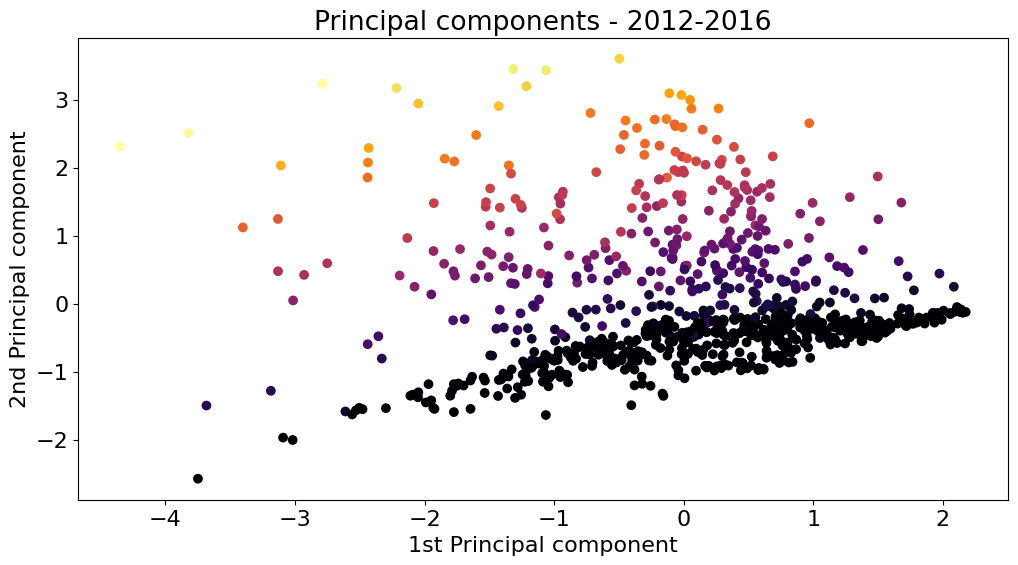

In [169]:
figx = plt.figure(figsize=(12,6))
plt.scatter(r_pca[:,0],r_pca[:,1], c = svmgs['area_x'], cmap='inferno')
plt.xlabel('1st Principal component')
plt.ylabel('2nd Principal component')
plt.title('Principal components - 2012-2016')

<Axes: >

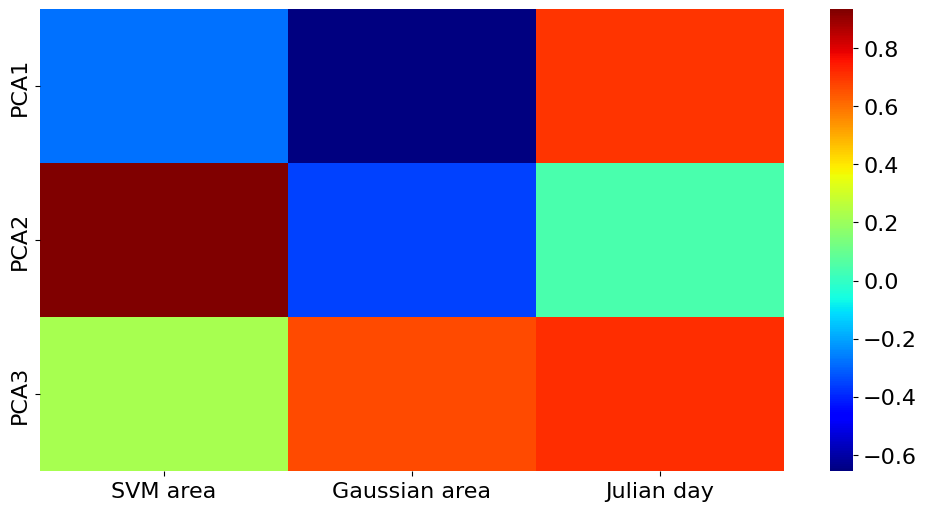

In [173]:
figx = plt.figure(figsize=(12,6))
map = pd.DataFrame(pca.components_, columns=['SVM area','Gaussian area','Julian day'])
sns.heatmap(map,cmap='jet',yticklabels=(['PCA1','PCA2','PCA3']))

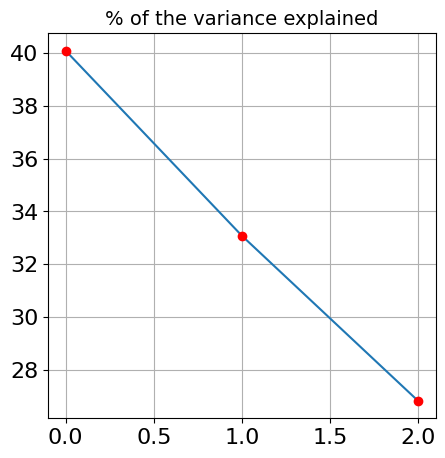

In [171]:
f, ax = plt.subplots(figsize=(5,5))
ax.plot(pca.explained_variance_ratio_[0:100]*100)
ax.plot(pca.explained_variance_ratio_[0:100]*100,'ro')
ax.set_title("% of the variance explained", fontsize=14)
ax.grid()

# Hypothesis testing

## Testing for normal data

### SVM method

In [75]:
gauss_data = rs2

In [76]:
gauss_data.head(4)

,value,geometry,date,area,perimeter,centroid,longitude,latitude,julian
0,0.0,"POLYGON ((500275 8558875, 500275 8558825, 5003...",2012-02-03,2500.0,200.0,POINT (500300 8558850),500300.000000,8.558850e+06,34.0
1,1.0,"POLYGON ((500825 8558275, 500825 8558225, 5007...",2012-02-03,17500.0,700.0,POINT (500871.429 8558207.143),500871.428571,8.558207e+06,34.0
2,1.0,"POLYGON ((501175 8558075, 501175 8558025, 5010...",2012-02-03,70000.0,1700.0,POINT (501280.357 8557910.714),501280.357143,8.557911e+06,34.0
3,0.0,"POLYGON ((499575 8557625, 499575 8557575, 4996...",2012-02-03,2500.0,200.0,POINT (499600 8557600),499600.000000,8.557600e+06,34.0


In [77]:
#When gauss_data = rs2
gauss_data['julian'] = gauss_data['date'].dt.strftime('%j')
gauss_data['julian'] = gauss_data['julian'].to_numpy()
gauss_data['julian'] = [float(i) for i in gauss_data['julian']]
gauss_data['julian'] = np.array(gauss_data['julian'])
print(gauss_data['julian'])

0          34.0
1          34.0
2          34.0
3          34.0
4          34.0
           ... 
1812784    61.0
1812785    61.0
1812787    61.0
1812789    61.0
1812790    61.0
Name: julian, Length: 1811193, dtype: float64


In [78]:
gauss_data = gauss_data.drop(['value','perimeter','longitude','latitude','geometry','centroid','date','julian'], axis=1)
print(gauss_data)

            area
0         2500.0
1        17500.0
2        70000.0
3         2500.0
4         2500.0
...          ...
1812784   2500.0
1812785   5000.0
1812787  10000.0
1812789   2500.0
1812790  15000.0

[1811193 rows x 1 columns]


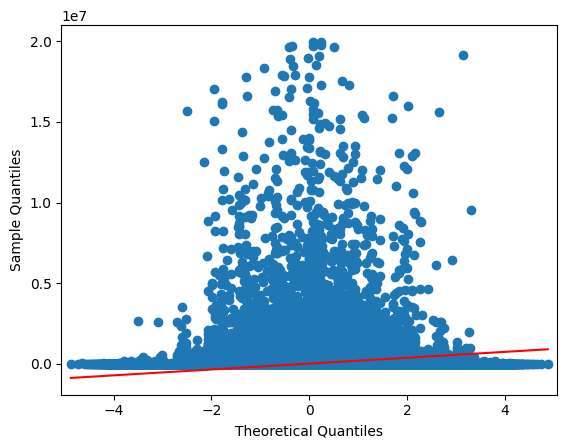

In [79]:
qqplot_data=qqplot(gauss_data, line='s').gca().lines #data is not normal. at all. test it another way. #line is: "r", "q", "45" or "s"

In [80]:
gd = gauss_data['area']
gd

0           2500.0
1          17500.0
2          70000.0
3           2500.0
4           2500.0
            ...   
1812784     2500.0
1812785     5000.0
1812787    10000.0
1812789     2500.0
1812790    15000.0
Name: area, Length: 1811193, dtype: float64

In [81]:
np.mean(gd),np.std(gd),np.min(gd),np.max(gd)

(17152.78272387316, 182154.19766844567, 2500.0, 19960000.0)

In [82]:
stat,p = normaltest(gd)

In [83]:
print(f"Statistic: {stat}")
print(f"P-value: {p}")
if p < 0.05:
    print("The data does not follow a normal distribution (reject null hypothesis).")
else:
    print("The data follows a normal distribution (fail to reject null hypothesis).")

Statistic: 5818618.854469605
P-value: 0.0
The data does not follow a normal distribution (reject null hypothesis).


### Gaussian method

In [111]:
gauss_data = rs2bin

In [86]:
gauss_data = iara

In [107]:
gauss_data.head(4)

,value,geometry,date,area,perimeter,centroid,longitude,latitude,julian
0,1.0,"POLYGON ((499625 8557925, 499625 8557875, 4995...",2012-01-02,37500.0,900.0,POINT (499626.667 8557783.333),499626.666667,8.557783e+06,2.0
1,1.0,"POLYGON ((522875 8557375, 522875 8557325, 5228...",2012-01-02,15000.0,700.0,POINT (522850 8557275),522850.000000,8.557275e+06,2.0
2,1.0,"POLYGON ((498975 8556975, 498975 8556825, 4990...",2012-01-02,12500.0,500.0,POINT (499020 8556890),499020.000000,8.556890e+06,2.0
3,1.0,"POLYGON ((523075 8556725, 523075 8556675, 5231...",2012-01-02,2500.0,200.0,POINT (523100 8556700),523100.000000,8.556700e+06,2.0


In [112]:
#When gauss_data = rs2bin
gauss_data['julian'] = gauss_data['date'].dt.strftime('%j')
gauss_data['julian'] = gauss_data['julian'].to_numpy()
gauss_data['julian'] = [float(i) for i in gauss_data['julian']]
gauss_data['julian'] = np.array(gauss_data['julian'])
print(gauss_data['julian'])

0          2.0
1          2.0
2          2.0
3          2.0
4          2.0
          ... 
146201    63.0
146202    63.0
146203    63.0
146205    63.0
146206    63.0
Name: julian, Length: 145022, dtype: float64


In [ ]:
#When gauss_data = iara
gauss_data['julian'] = gauss_data['date'].dt.strftime('%j')
gauss_data['julian'] = gauss_data['julian'].to_numpy()
gauss_data['julian'] = [float(i) for i in gauss_data['julian']]
gauss_data['julian'] = np.array(gauss_data['julian'])
print(gauss_data['julian'])

In [113]:
#When gauss_data = rs2bin
gauss_data = gauss_data.drop(['value','perimeter','longitude','latitude','geometry','centroid','date','julian'], axis=1)
print(gauss_data)

             area
0         37500.0
1         15000.0
2         12500.0
3          2500.0
4          2500.0
...           ...
146201    40000.0
146202  2700000.0
146203    30000.0
146205     5000.0
146206    40000.0

[145022 rows x 1 columns]


In [89]:
#When gauss_data = iara
gauss_data = gauss_data.drop(['value','date'], axis=1)
print(gauss_data)

            area  julian
0      2950000.0     2.0
2     35235000.0     3.0
4     26002500.0     5.0
6     16237500.0     6.0
8     66387500.0     9.0
...          ...     ...
1253  44572500.0    54.0
1255  89947500.0    58.0
1257  56337500.0    60.0
1259  39085000.0    61.0
1261  23830000.0    63.0

[743 rows x 2 columns]


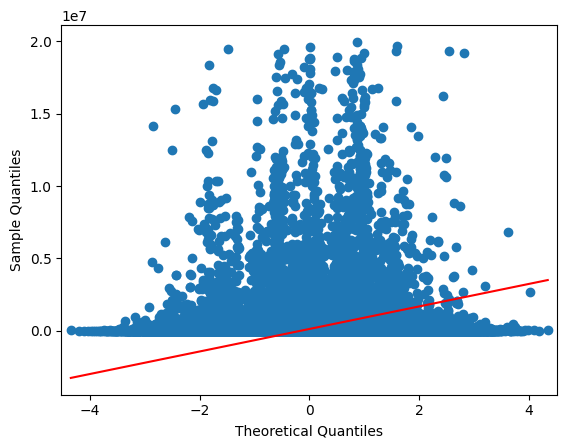

In [119]:
qqplot_data=qqplot(gauss_data, line='s').gca().lines #data is not normal. at all. test it another way. #line is: "r", "q", "45" or "s"

In [73]:
gd = gauss_data['area']
gd

0           37500.0
1           15000.0
2           12500.0
3            2500.0
4            2500.0
            ...    
146201      40000.0
146202    2700000.0
146203      30000.0
146205       5000.0
146206      40000.0
Name: area, Length: 145022, dtype: float64

In [120]:
np.mean(gd),np.std(gd),np.min(gd),np.max(gd)

(131247.638289363, 777085.8503269099, 2500.0, 19947500.0)

In [74]:
stat,p = normaltest(gd)

In [81]:
print(f"Statistic: {stat}")
print(f"P-value: {p}")
if p < 0.05:
    print("The data does not follow a normal distribution (reject null hypothesis).")
else:
    print("The data follows a normal distribution (fail to reject null hypothesis).")

Statistic: 263482.6010931189
P-value: 0.0
The data does not follow a normal distribution (reject null hypothesis).
